# **2214 - Asset Management: Group Assignment T3 2025**

Group 19

Laura Rebelo, 47408

Marco Piccolo, 63996

Philipp Goetting, 64737

Teresa Mendoça, 42896

##### Professor Formulas Preamble

In [3]:
# Let's use our functions that we defined earlier in the course

# Function to compute portfolio return from weights and asset returns
def portfolio_return(weights, returns):
    """
    - Computes the return on a portfolio from constituent returns and weights
    - Weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


# Function to compute portfolio standard deviation from weights and asset covariance matrix
def portfolio_vol(weights, covmat):
    """
    - Computes the vol of a portfolio from a covariance matrix and constituent weights
    - Weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5


# Function to compute the negative of the Sharpe ratio for a portfolio
def neg_sharpe(weights, riskfree_rate, er, cov):
    """
    Returns the negative of the Sharpe ratio
    of the given portfolio
    """
    r = portfolio_return(weights, er)
    vol = portfolio_vol(weights, cov)
    return -(r - riskfree_rate)/vol


# Function to compute the weights of the maximum Share ratio portfolio
# (minimizes the negative of the Sharpe ratio, using the "neg_sharpe" function)
def max_sr(riskfree_rate, er, cov, bounds):
    """
    Returns the weights of the portfolio that gives you the maximum Sharpe ratio
    given the riskfree rate, expected returns and the covariance matrix of returns
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Function to compute portfolio weights minimizing PF variance given constraints
# (you need to import the minimize function from scipy.optimize)
def minimize_vol(er, cov, bounds):
    """
    Returns the weights of the portfolio with the minimum variance
    for given weight bounds, a given set of expected returns
    and a covariance matrix.
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)

    # Construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Function to compute portfolio weights minimizing PF variance given constraints
# (additional constraint to minimize_vol function: achieve target return target_mu)
def minimize_vol_target_mu(er, cov, bounds, mu_target, init_guess):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]

    def er_equal_to_mu_target(weights):
        return weights.T @ er - mu_target

    # Construct the constraints
    constraints = [{'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1},   # weights sum to 1
                   {'type': 'eq',
                        'fun': er_equal_to_mu_target      # er equal to target
    }]

    weights = minimize(portfolio_vol, init_guess,
                       args=(cov), method='SLSQP',
                       options={'disp': False},
                       constraints=constraints,
                       bounds=bounds)
    return weights.x


# Trace out Capital Allocation Line
def CAL(rf, maxSR, x):
    return rf + maxSR*x


# Function to compute the weights of the minimum variance portfolio given a
# DataFrame with asset returns and weight bounds (the function then uses the
# minimize_vol function above)
def weight_gmv(r, bounds):
    er = r.mean()
    cov = r.cov()
    return minimize_vol(er, cov, bounds)


# Function to compute equal weights based on the number of input assets
def weight_ew(r):
    w = [ 1/len(r.columns) for x in range(len(r.columns))]
    w = np.array(w)
    return w


# Function to compute the drawdown
def drawdown(return_series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the price index,
       the high water mark, and
       the percentage drawdown
    """
    price_index = 1*(1+return_series).cumprod()
    high_water_mark = price_index.cummax()
    drawdowns = (high_water_mark - price_index)/high_water_mark
    return pd.DataFrame({"Price Index": price_index,
                         "High Water Mark": high_water_mark,
                         "Drawdown": drawdowns})


# Function to perform backtest on portfolio strategy given a weighting scheme
def backtest_ws(r, weighting, estimation_window=60, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of arguments
    """
    n_periods = r.shape[0]

    # List of overlapping rolling return windows for estimation
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]

    # List of portfolio weights over time
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]

    # Convert to DataFrame
    weights = pd.DataFrame(weights[:-1], index=r.iloc[estimation_window:].index, columns=r.columns) # make sure to
                # only use data up to time t-1 to estimate weights for month t
    returns = (weights * r).sum(axis="columns",  min_count=1) # mincount is to generate NAs if all inputs are NAs
    return returns, weights


# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm

# Exercise 1

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### Load the Data

In [7]:

fund_gross_return = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_gross_ret", header=0, index_col=0)/100
fund_gross_return.index = pd.to_datetime(fund_gross_return.index, format="%Y%m").to_period('M')

funds_ter = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_TER", header=0, index_col=0)/100
funds_ter.index = pd.to_datetime(funds_ter.index, format="%Y%m").to_period('M')

funds_aum = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_AUM", header=0, index_col=0)/10**6
funds_aum.index = pd.to_datetime(funds_aum.index, format="%Y%m").to_period('M')

consumer_price_index = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "cpi", header=0, index_col=0)
consumer_price_index.index = pd.to_datetime(consumer_price_index.index, format="%Y%m").to_period('M')

index_return = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "index_ret", header=0, index_col=0)/100
index_return.index = pd.to_datetime(index_return.index, format="%Y%m").to_period('M')

fama_french = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "FF", header=0, index_col=0)/100
fama_french.index = pd.to_datetime(fama_french.index, format="%Y%m").to_period('M')

In [8]:
# Rename the columns
index_return = index_return.rename(columns={
                        'S&P 500 TR USD': 'SNP',
                        'Russell 2000 TR USD': 'R2',
                        'Russell 3000 Growth TR USD': 'R3G',
                        'Russell 3000 Value TR USD': 'R3V'
                        })

fama_french = fama_french.rename(columns={'Mkt-RF': 'MktRf'})

#### Select common period

In [10]:
# Restrict datasets to common periods
common_period = fund_gross_return.dropna().index
fund_gross_return, funds_ter, funds_aum, consumer_price_index, index_return, fama_french = [df.loc[common_period] for df in [fund_gross_return, funds_ter, funds_aum, consumer_price_index, index_return, fama_french]]

# Extract Risk-Free Rate
risk_free_rate = fama_french['RF']

### Question 1

#### Question 1.a
Arithmetic and geometric mean returns, both gross (i.e., before-fee) and net (i.e., after-fee)

In [13]:
# Compute Net Returns
fund_net_return = fund_gross_return - funds_ter
fund_net_return.round(4)

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10
Date,,,,,,,,,,
1998-10,0.0409,0.0629,0.0826,0.0676,0.1190,0.0456,0.0060,0.0977,0.0548,0.0579
1998-11,0.0268,0.0663,0.0571,0.0552,0.0743,0.0259,0.0998,0.0655,0.0728,0.0676
1998-12,0.0980,0.0771,0.0650,0.0494,0.1306,-0.0012,0.1295,0.0350,0.0426,0.1277
1999-01,0.0088,0.0228,0.0364,0.0274,0.0907,0.0083,0.1129,-0.0042,0.0076,-0.0014
1999-02,-0.0929,-0.0358,-0.0330,-0.0055,-0.0213,-0.0354,-0.1031,-0.0090,-0.0612,-0.0317
...,...,...,...,...,...,...,...,...,...,...
2024-08,0.0338,0.0209,0.0243,0.0183,0.0077,0.0365,0.0150,0.0274,0.0131,0.0115
2024-09,0.0367,0.0151,0.0208,0.0134,0.0276,0.0172,0.0342,0.0063,0.0072,0.0353
2024-10,-0.0167,-0.0057,-0.0094,-0.0203,0.0021,-0.0084,-0.0078,0.0328,-0.0197,0.0077


In [14]:
# Compute Annualized Returns
annualized_gross_arith_mean = fund_gross_return.mean() * 12
annualized_geo_mean_gross = fund_gross_return.apply(lambda returns: (np.prod(1 + returns) ** (12 / len(returns))) - 1)

annualized_net_arith_mean = fund_net_return.mean() * 12
annualized_geo_mean_net = fund_net_return.apply(lambda returns: (np.prod(1 + returns) ** (12 / len(returns))) - 1)

# Store Annualized Results
annualized_means = pd.DataFrame({
    'Arithmetic Mean Gross': annualized_gross_arith_mean.round(3),
    'Geometric Mean Gross': annualized_geo_mean_gross.round(3),
    'Arithmetic Mean Net': annualized_net_arith_mean.round(3),
    'Geometric Mean Net': annualized_geo_mean_net.round(3)
    })

annualized_means

,Arithmetic Mean Gross,Geometric Mean Gross,Arithmetic Mean Net,Geometric Mean Net
Fund 1,0.119,0.098,0.105,0.082
Fund 2,0.097,0.089,0.088,0.080
Fund 3,0.098,0.089,0.095,0.086
Fund 4,0.110,0.102,0.096,0.087
Fund 5,0.101,0.084,0.083,0.066
Fund 6,0.081,0.073,0.069,0.061
Fund 7,0.146,0.116,0.135,0.104
Fund 8,0.120,0.106,0.111,0.096
Fund 9,0.105,0.091,0.102,0.087
Fund 10,0.122,0.105,0.103,0.084


By comparing the approximated geometric mean and the actual geometric mean, we find that the approximation differs by 0.04 from the actual value.

#### Question 1.b
CAPM alphas with respect to the market (gross and net, where net alphas are simply gross alphas obtained from the regressions minus fees)

**CAPM Estimates an assets' returns:**
$
E(R_i) = R_f + \beta_i (E(R_m) - R_f)
$

**CAPM Regression:** Esitmates a fund's alpha ($\alpha$) and beta ($\beta$)<br>
$
(R_{i,t} - R_f) = \alpha + \beta (R_{m,t} - R_f) + \epsilon_t
$


- **CAPM $\alpha$** –> Measures the excess return unexplained by the market
- **CAPM $\beta$** –> Reflects how closely the fund follows market movements. The lower the stock’s beta. the lower the covariance with the market, and the higher the diversification benefits.


Alpha ($\alpha$): Measures active management’s contribution to performance.

- $\alpha$ > 0 → Fund outperforms the market expectation.

- $\alpha$ < 0 → Fund underperforms relative to market risk.<br>

Beta ($\beta$): Measures market risk exposure.

- $\beta$ > 1 → Fund is more volatile than the market.

- $\beta$ < 1 → Fund is less volatile than the market.<br>


**CAPM Alpha (Gross):** Measures pre-fee outperformance.<br>

**CAPM Alpha (Net):** Reflects investor’s actual return after costs.<br>

**Beta:** Indicates the fund’s market risk level.<br>

In [18]:
# Calculate market excess return once
market_excess_return = index_return["SNP"] - risk_free_rate  # Market return minus risk-free rate
X_full = sm.add_constant(market_excess_return)  # Add constant term for the intercept

capm_results = {}

for fund in fund_gross_return.columns:
    # Compute fund's excess returns and drop any missing values
    Y = (fund_gross_return[fund] - risk_free_rate).dropna()
    
    # Align X with the available dates in Y
    X = X_full.loc[Y.index]
    
    # Run CAPM regression using aligned data
    model = sm.OLS(Y, X).fit()
    
    # Extract CAPM parameters
    capm_alpha = model.params["const"]  # Intercept (alpha)
    capm_beta = model.params[X.columns[1]]  # Slope (beta)
    
    # Adjust gross alpha for fees to get net alpha.
    # Note: We also align the funds_ter data with the regression period.
    fee_mean = funds_ter[fund].loc[Y.index].mean()
    capm_alpha_net = capm_alpha - fee_mean
    
    # Annualize alpha by multiplying by 12
    capm_results[fund] = {
        "CAPM Alpha (Gross)": capm_alpha * 12,
        "CAPM Alpha (Net)": capm_alpha_net * 12,
        "Beta": capm_beta
    }

# Convert results to a DataFrame, round for display, and insert fund names
capm_results_df = pd.DataFrame(capm_results).T.round(4)

capm_results_df


,CAPM Alpha (Gross),CAPM Alpha (Net),Beta
Fund 1,0.0056,-0.0086,1.2033
Fund 2,0.0024,-0.0066,0.9691
Fund 3,-0.0009,-0.0034,1.0170
Fund 4,0.0162,0.0026,0.9502
Fund 5,-0.0111,-0.0282,1.1816
Fund 6,-0.0061,-0.0175,0.8668
Fund 7,0.0187,0.0080,1.3817
Fund 8,0.0185,0.0093,1.0598
Fund 9,0.0032,-0.0004,1.0603
Fund 10,0.0130,-0.0056,1.1479


##### Interpretation
**Best Performing Funds (High Net Alpha):** –> Outpeerforming the market after adjusting risk.
- Fund 7 (Net Alpha: 0.0178)
- Fund 8 (Net Alpha: 0.01769)
- Fund 4 (Net Alpha: 0.01504)

**Underperforming Funds (Negative Alpha):**
- Fund 5 (Net Alpha: -0.01248)
- Fund 6 (Net Alpha: -0.00707)
- Fund 3 (Net Alpha: -0.00109)

**High Beta (More Volatile):**
- Fund 7 (1.38)
- Fund 10 (1.14)
- Fund 1 (1.20)

**Low Beta (Less Volatile):**
- Fund 6 (0.87)
- Fund 4 (0.95)
- Fund 2 (0.97)

Investors looking for high growth with high risk should consider **Fund 7** & **Fund 8**.<br>**Fund 4** is a balanced choice with solid performance and moderate risk.<br>**Fund 5** is the worst investment, as it fails to deliver positive risk-adjusted returns.


#### Question 1.c
Risk measures of returns, including standard deviations, skewness, kurtosis, the maximum drawdown, and Sharpe ratios.

**Sharp Ratio**<br><br>
$
SR_p = \frac{E(r_p)-r_f}{\sigma_p}
$

- Risk Measures for Gross Returns

In [23]:
# Risk Measures for Gross Returns
std_dev_gross = fund_gross_return.std() * np.sqrt(12)  # Annualized standard deviation (volatility)
skewness_gross = fund_gross_return.skew()  # Skewness of returns
kurtosis_gross = fund_gross_return.kurtosis()  # Kurtosis (fat-tail risk)
sharpe_ratio_gross = (annualized_gross_arith_mean - risk_free_rate.mean() * 12) / std_dev_gross
max_drawdown_gross = fund_gross_return.apply(lambda x: drawdown(x)["Drawdown"].max())

gross_risk_measures = pd.DataFrame({
    'Std Dev Gross': std_dev_gross.round(4),
    'Skewness Gross': skewness_gross.round(4),
    'Kurtosis Gross': kurtosis_gross.round(4),
    'Sharpe Ratio Gross':sharpe_ratio_gross.round(4),
    'Max Drowdown Gross': max_drawdown_gross.round(4)
})

gross_risk_measures.round(3)


,Std Dev Gross,Skewness Gross,Kurtosis Gross,Sharpe Ratio Gross,Max Drowdown Gross
Fund 1,0.224,-0.357,0.503,0.446,0.546
Fund 2,0.151,-0.504,1.204,0.518,0.520
Fund 3,0.156,-0.495,0.872,0.506,0.511
Fund 4,0.155,-0.597,1.660,0.586,0.496
Fund 5,0.196,-0.379,1.128,0.416,0.680
Fund 6,0.141,-0.491,0.917,0.439,0.499
Fund 7,0.265,-0.475,2.687,0.480,0.804
Fund 8,0.195,-0.361,1.712,0.520,0.615
Fund 9,0.188,-0.578,1.401,0.460,0.526
Fund 10,0.208,-0.552,1.486,0.496,0.626


- Risk Measures for Net Returns

In [25]:
# Risk Measures for Net Returns
std_dev_net = fund_net_return.std() * np.sqrt(12)  # Annualized standard deviation (volatility)
skewness_net = fund_net_return.skew()  # Skewness of returns
kurtosis_net = fund_net_return.kurtosis()  # Kurtosis (fat-tail risk)
sharpe_ratio_net = (annualized_net_arith_mean - risk_free_rate.mean() * 12) / std_dev_net
max_drawdown_net = fund_net_return.apply(lambda x: drawdown(x)["Drawdown"].max())

net_risk_measures = pd.DataFrame({
    'Std Dev Net': std_dev_net.round(4),
    'Skewness Net': skewness_net.round(4),
    'Kurtosis Net': kurtosis_net.round(4),
    'Sharpe Ratio Net':sharpe_ratio_net.round(4),
    'Max Drowdown Net': max_drawdown_net.round(4)
})

net_risk_measures.round(3)


,Std Dev Net,Skewness Net,Kurtosis Net,Sharpe Ratio Net,Max Drowdown Net
Fund 1,0.224,-0.358,0.504,0.383,0.556
Fund 2,0.151,-0.505,1.206,0.458,0.526
Fund 3,0.156,-0.495,0.871,0.490,0.513
Fund 4,0.155,-0.597,1.660,0.498,0.506
Fund 5,0.196,-0.379,1.129,0.329,0.690
Fund 6,0.141,-0.490,0.918,0.358,0.510
Fund 7,0.265,-0.476,2.687,0.439,0.809
Fund 8,0.195,-0.362,1.711,0.474,0.621
Fund 9,0.188,-0.578,1.402,0.440,0.528
Fund 10,0.208,-0.550,1.489,0.406,0.637


In [26]:
# Store Performance Metrics
performance_analysis = pd.concat([annualized_means, gross_risk_measures, net_risk_measures, capm_results_df],axis=1)

performance_analysis

,Arithmetic Mean Gross,Geometric Mean Gross,Arithmetic Mean Net,Geometric Mean Net,Std Dev Gross,Skewness Gross,Kurtosis Gross,Sharpe Ratio Gross,Max Drowdown Gross,Std Dev Net,Skewness Net,Kurtosis Net,Sharpe Ratio Net,Max Drowdown Net,CAPM Alpha (Gross),CAPM Alpha (Net),Beta
Fund 1,0.119,0.098,0.105,0.082,0.2238,-0.3572,0.5028,0.4464,0.5459,0.2239,-0.3584,0.5045,0.3826,0.5559,0.0056,-0.0086,1.2033
Fund 2,0.097,0.089,0.088,0.080,0.1512,-0.5045,1.2045,0.5184,0.5196,0.1512,-0.5050,1.2063,0.4585,0.5261,0.0024,-0.0066,0.9691
Fund 3,0.098,0.089,0.095,0.086,0.1558,-0.4951,0.8724,0.5059,0.5115,0.1558,-0.4946,0.8712,0.4901,0.5133,-0.0009,-0.0034,1.0170
Fund 4,0.110,0.102,0.096,0.087,0.1547,-0.5970,1.6595,0.5859,0.4965,0.1547,-0.5973,1.6599,0.4984,0.5061,0.0162,0.0026,0.9502
Fund 5,0.101,0.084,0.083,0.066,0.1961,-0.3793,1.1285,0.4158,0.6797,0.1961,-0.3791,1.1289,0.3286,0.6896,-0.0111,-0.0282,1.1816
Fund 6,0.081,0.073,0.069,0.061,0.1407,-0.4907,0.9173,0.4393,0.4992,0.1407,-0.4904,0.9179,0.3585,0.5096,-0.0061,-0.0175,0.8668
Fund 7,0.146,0.116,0.135,0.104,0.2648,-0.4750,2.6866,0.4795,0.8041,0.2648,-0.4762,2.6874,0.4392,0.8091,0.0187,0.0080,1.3817
Fund 8,0.120,0.106,0.111,0.096,0.1951,-0.3613,1.7122,0.5204,0.6146,0.1951,-0.3621,1.7110,0.4735,0.6214,0.0185,0.0093,1.0598
Fund 9,0.105,0.091,0.102,0.087,0.1877,-0.5776,1.4013,0.4595,0.5260,0.1877,-0.5782,1.4019,0.4405,0.5283,0.0032,-0.0004,1.0603
Fund 10,0.122,0.105,0.103,0.084,0.2075,-0.5525,1.4862,0.4961,0.6261,0.2075,-0.5499,1.4888,0.4064,0.6371,0.0130,-0.0056,1.1479


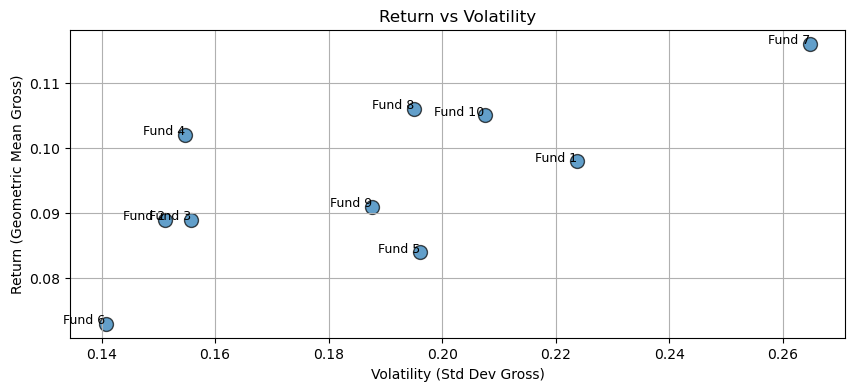

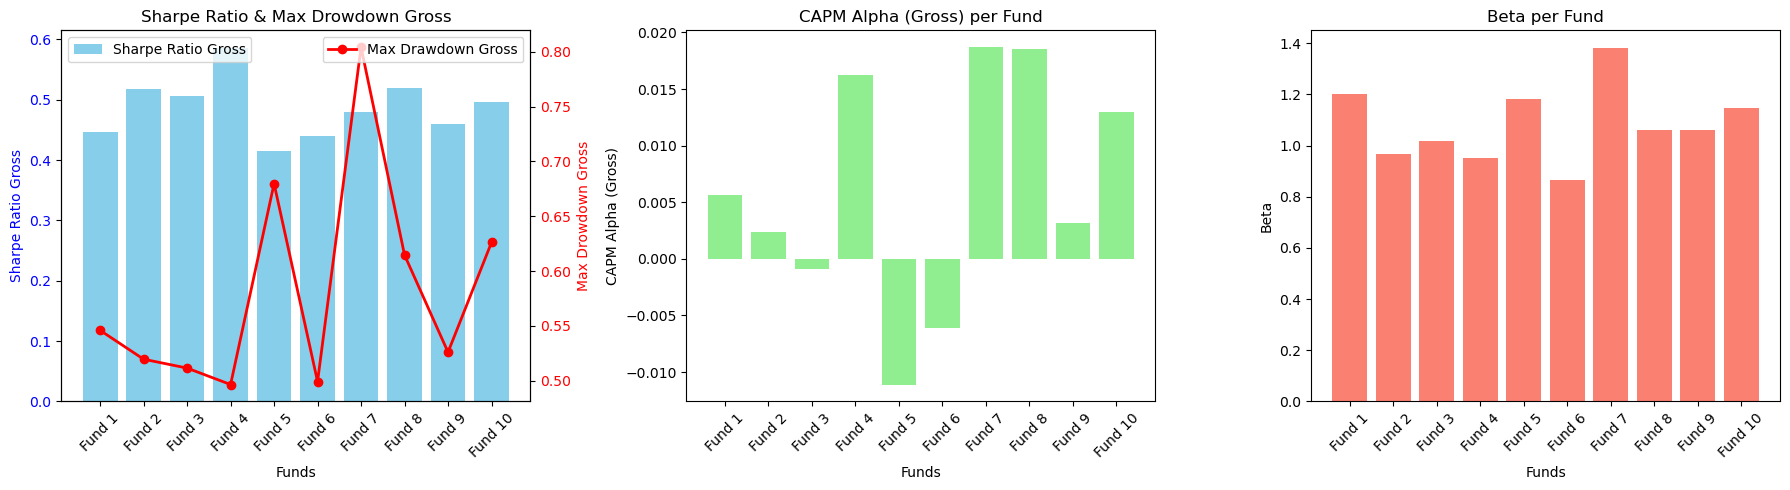

In [27]:
# Scatterplot (Return vs Volatility)
plt.figure(figsize=(10, 4))

# Scatter plot
plt.scatter(performance_analysis['Std Dev Gross'],
            performance_analysis['Geometric Mean Gross'],
            s=100, alpha=0.7, edgecolors='k')

# Label each point with the index (assuming the fund name is the DataFrame index)
for idx, row in performance_analysis.iterrows():
    plt.text(row['Std Dev Gross'],
             row['Geometric Mean Gross'],
             idx,               # or row['SomeFundNameColumn'] if you store fund names in a column
             fontsize=9,
             ha='right')        # Adjust horizontal alignment as desired

plt.xlabel('Volatility (Std Dev Gross)')
plt.ylabel('Return (Geometric Mean Gross)')
plt.title('Return vs Volatility')
plt.grid(True)
plt.show()

# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Sharpe Ratio & Max Drawdown Gross per Fund
ax1 = axs[0]
# Plot Sharpe Ratio (Gross) as bars using the DataFrame index
ax1.bar(performance_analysis.index, performance_analysis['Sharpe Ratio Gross'], 
        color='skyblue', label='Sharpe Ratio Gross')
ax1.set_xlabel('Funds')
ax1.set_ylabel('Sharpe Ratio Gross', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Create a secondary y-axis for Max Drawdown Gross (line plot)
ax2 = ax1.twinx()
ax2.plot(performance_analysis.index, performance_analysis['Max Drowdown Gross'], 
         color='red', marker='o', label='Max Drawdown Gross', linewidth=2)
ax2.set_ylabel('Max Drowdown Gross', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Sharpe Ratio & Max Drowdown Gross')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Bar Chart - CAPM Alpha (Gross) per Fund
axs[1].bar(performance_analysis.index, performance_analysis['CAPM Alpha (Gross)'], color='lightgreen')
axs[1].set_xlabel('Funds')
axs[1].set_ylabel('CAPM Alpha (Gross)')
axs[1].set_title('CAPM Alpha (Gross) per Fund')
axs[1].tick_params(axis='x', rotation=45)

# Bar Chart - Beta per Fund
axs[2].bar(performance_analysis.index, performance_analysis['Beta'], color='salmon')
axs[2].set_xlabel('Funds')
axs[2].set_ylabel('Beta')
axs[2].set_title('Beta per Fund')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



##### Fund Comparison

- **Fund 1** has delivered positive returns before and after fees, but the impact of fees has notably reduced its net returns, especially when considering compounded returns. In terms of risk, the fund has a high level of volatility with a standard deviation of about 22%, along with a significant maximum drawdown of over 50%, which shows there's a high potential for losses in market downturns. The fund’s gross Sharpe ratio suggests it's providing a positive return relative to risk, though this improves slightly when accounting for fees. On the downside, its negative skewness and low kurtosis indicate that the fund is more likely to experience losses than gains, but extreme events are unlikely. Prior to fees, the fund slightly outperformed the market, but after fees, it underperforms, being more volatile than the market, given its beta of 1.2. While the fund shows strong returns before fees, the fees have a significant impact on both its risk-adjusted performance and long-term results. Given its relatively high risk and potential for large losses, this fund is more suited to investors with a higher risk tolerance. 

- **Fund 2** delivers moderate returns both before and after fees, with a gross arithmetic mean of 9.7%. The fund has low volatility (15.1%), but its negative skewness and high kurtosis indicate that it may experience more frequent losses than gains, with the potential for extreme outcomes. Its Sharpe ratio suggests it provides a solid return relative to the risk taken, but the fees reduce its overall performance. Although the fund slightly outperforms the market on a gross basis, it underperforms after accounting for fees. Given its relatively low risk and moderate performance.

- **Fund 3** offers moderate returns both gross and net, with a gross arithmetic mean of 9.8%. The fund has low volatility (15.6%), but like Fund 2, it has negative skewness, suggesting a higher likelihood of losses than gains. Its Sharpe ratio indicates reasonable risk-adjusted returns, but after fees, the performance drops slightly, resulting in a net underperformance against the market. Its beta of 1.02 indicates that on average the fund moves with the market. This fund is more suitable for investors seeking lower volatility.

- **Fund 4** provides good returns (11% gross arithmetic mean), but its fees reduce net performance. The fund has moderate volatility (15.5%) and displays a negative skew, signaling a higher risk of loss. The significant kurtosis indicates the possibility of extreme events, such as large gains or losses. Its gross Sharpe ratio is solid, but net returns decline once fees are considered. While it slightly outperforms the market on a gross basis, the fees significantly reduce net returns, making it only slightly better than the market. This fund is a balanced choice with solid performance and moderate risk. 

- **Fund 5** shows decent gross returns (10.1%), but its fees significantly reduce net performance, especially considering its high volatility (19.6%). The fund has a negative skew, suggesting more frequent losses, and a high kurtosis, implying the possibility of extreme events. Its Sharpe ratio is lower (0.42), indicating it fails to deliver positive risk-adjusted returns. The fund’s performance is solid before fees, but it underperforms after fees. 

- **Fund 6** has lower returns (8.1% gross arithmetic mean) and low volatility (14.1%), making it less risky. However, its negative skewness suggests that it has a greater likelihood of negative returns. The Sharpe ratio indicates decent risk-adjusted returns, but net returns suffer due to fees. This fund provides a stable, lower-risk option, but its performance, particularly after fees, doesn’t offer significant outperformance compared to the market. It's more suitable for conservative investors seeking lower volatility, but its fees may limit overall growth.

- **Fund 7** presents the highest gross return (14.6%) but it also comes with the highest volatility (26.5%) and a significant potential for large losses as its maximum drawdown is over 80%. The fund’s negative skew and high kurtosis indicate that it has a higher chance of negative outcomes, and given its kurtosis value, extreme events are likely. Its gross performance is impressive, but fees reduce net returns. Even so, it still delivers decent risk-adjusted returns before fees. This fund is best suited for investors with a high risk tolerance who are willing to accept large fluctuations in performance. 

- **Fund 8** offers solid gross returns (12%) with relatively high volatility (19.5%). It has a negative skew, suggesting a higher likelihood of losses. Its high kurtosis (1.71) suggests that the fund has a higher likelihood of experiencing extreme returns, either big gains or big losses, compared to a normal distribution. The Sharpe ratio is good, reflecting positive risk-adjusted returns, though fees reduce net returns. This fund is suitable for investors looking for high growth and risk. 

- **Fund 9** provides moderate gross returns (10.5%) with higher volatility (18.8%). It has negative skewness, suggesting a higher chance of losses, but its kurtosis is moderate. The Sharpe ratio indicates positive risk-adjusted returns before fees, but net performance lags due to the impact of fees. After fees, the fund slightly underperforms the market. This fund is appropriate for moderately risk-tolerant investors.

- **Fund 10** provides solid returns (12.2% gross arithmetic mean) with moderate volatility (20.8%). It has negative skewness, meaning there is a greater likelihood of losses, and extreme events are more or less likely. Its Sharpe ratio reflects good risk-adjusted performance, though fees reduce net returns. The fund slightly outperforms the market on a gross basis but underperforms once fees are considered. 




### Question 2
Run factor regressions using the FF 5-Factor Model as the benchmark.


#### Question 2.a
Report annualized FF5 alphas (gross and net).

In [31]:
# Perform Fama-French Five-Factor Model Regression to extract Gross and Net Alpha
ff5_alphas = {}

for fund in fund_gross_return.columns:
    # Compute excess return (gross)
    fund_excess_return = fund_gross_return[fund] - risk_free_rate

    # Set up Fama-French 5-factor model
    X = sm.add_constant(fama_french[["MktRf", "SMB", "HML", "RMW", "CMA"]])  # FF5 factors
    Y = fund_excess_return

    # Run regression
    model = sm.OLS(Y, X, missing="drop").fit()

    # Extract Gross Alpha (Annualized)
    gross_alpha = model.params["const"] * 12

    # Compute Net Alpha (Gross Alpha - Fund Fees)
    avg_fund_fee = funds_ter[fund].mean() * 12  # Convert monthly TER to annualized
    net_alpha = gross_alpha - avg_fund_fee

    # Store results
    ff5_alphas[fund] = {"Gross Alpha (Annualized)": round(gross_alpha, 5),
                        "Net Alpha (Annualized)": round(net_alpha, 5)}

# Convert dictionary to DataFrame
ff5_alphas_df = pd.DataFrame.from_dict(ff5_alphas, orient="index").round(4)
ff5_alphas_df


,Gross Alpha (Annualized),Net Alpha (Annualized)
Fund 1,0.0037,-0.0106
Fund 2,-0.0036,-0.0127
Fund 3,-0.0060,-0.0085
Fund 4,-0.0023,-0.0158
Fund 5,-0.0014,-0.0186
Fund 6,-0.0131,-0.0245
Fund 7,0.0643,0.0536
Fund 8,0.0287,0.0196
Fund 9,-0.0070,-0.0106
Fund 10,0.0183,-0.0003


#### Question 2.b
Report all factor betas. Based on factor exposures, characterize the stocks that Fund 7 invests in.

In [33]:
# Extracting Factor Betas from FF5 Model
ff5_betas = {}
for fund in fund_gross_return.columns:
    fund_excess_return = fund_gross_return[fund] - risk_free_rate
    X = sm.add_constant(fama_french[["MktRf", "SMB", "HML", "RMW", "CMA"]])
    Y = fund_excess_return
    model = sm.OLS(Y, X, missing="drop").fit()
    ff5_betas[fund] = model.params.drop("const").to_dict()

ff5_betas_df = pd.DataFrame.from_dict(ff5_betas, orient="index").round(5)

# Rename columns to add "Beta_" prefix
ff5_betas_df = ff5_betas_df.rename(columns=lambda col: f"Beta_{col}")

# Merge with ff5_alphas_df on the index
ff5_df = pd.merge(ff5_alphas_df, ff5_betas_df, left_index=True, right_index=True, how='inner')
ff5_df.round(5)


,Gross Alpha (Annualized),Net Alpha (Annualized),Beta_MktRf,Beta_SMB,Beta_HML,Beta_RMW,Beta_CMA
Fund 1,0.0037,-0.0106,1.07471,0.67230,-0.16412,-0.04784,-0.21724
Fund 2,-0.0036,-0.0127,0.97063,-0.08682,0.03305,0.09924,0.00225
Fund 3,-0.0060,-0.0085,1.01971,-0.13273,0.03120,0.09332,0.00950
Fund 4,-0.0023,-0.0158,0.96007,0.12942,0.10285,0.15896,0.16562
Fund 5,-0.0014,-0.0186,1.12576,-0.10015,0.36618,-0.17640,-0.06705
Fund 6,-0.0131,-0.0245,0.87673,-0.10365,0.19924,0.04634,0.10484
Fund 7,0.0643,0.0536,1.21186,-0.07672,-0.38137,-0.60559,-0.30161
Fund 8,0.0287,0.0196,1.00096,-0.10263,0.79552,-0.15627,-0.21002
Fund 9,-0.0070,-0.0106,0.97354,0.58197,0.03027,0.03488,-0.08968
Fund 10,0.0183,-0.0003,1.06169,0.28596,-0.21424,-0.14287,-0.08301


##### Fund 7 Investing Characteristics

Fund 7 follows a growth-oriented investment strategy, favoring high-growth companies over traditional value stocks. This is evident from its negative HML (-0.38), which suggests it prioritizes firms with strong expansion potential rather than those that appear undervalued.
It also prefers large-cap stocks, as indicated by the negative SMB (-0.08). This means the fund leans toward larger, more established companies, which typically offer more stability compared to small-cap stocks.
At the same time, Fund 7 carries above-average market exposure, with a market beta of 1.21. This suggests that it moves more aggressively than the market. If the market rises or falls by 10%, this fund would be expected to move by about 12.1% in the same direction.
Additionally, the fund steers away from highly profitable firms, as seen in its negative RMW (-0.61). This suggests a focus on companies that are still scaling and reinvesting in their growth, rather than those with strong existing profit margins.
Finally, its negative CMA (-0.30) indicates a preference for firms with lower capital expenditures, meaning it may favor businesses that don’t require heavy reinvestment to sustain operations, possibly leaning toward asset-light or tech-driven companies.

#### Question 2.c
The appendix contains strategy descriptions written by fund  analysts for 5 out of the 10 funds. Match the strategy descriptions A-E with the corresponding funds. Explain.

- **Fund 7-Strategy A:**<br>
Fund 7 is an excellent choice for investors seeking high-growth opportunities in innovative sectors. It exhibits the highest gross and net returns (14.6% and 13.5%, respectively), highlighting its strong performance. More importantly, Fund 7's factor exposures make it particularly well-suited for strategy A. The fund has a high beta (1.2119), suggesting a greater sensitivity to market growth and risk, which is ideal for capturing secular growth trends in high-potential industries like technology and AI. The fund's beta for SMB (0.6723) shows a tendency toward smaller, potentially high-growth companies, while its beta for HML (-0.1641) suggests a preference for growth stocks over value stocks. Additionally, the fund has a negative beta for RMW (-0.2172) and CMA (-0.2172), which is consistent with the fund's focus on high-growth, innovative companies that may not yet be profitable but have strong potential for future profitability as they scale. This combination of factor betas suggests that Fund 7 is well-positioned to capture the upside of emerging, innovative companies while balancing risk and return through strategic factor exposures.<br><br>

- **Fund 4-Strategy B:**<br>
Fund 4 appears to be a suitable choice for strategy B, given its factor exposures. With a market beta of 0.96007, the fund demonstrates a slightly lower sensitivity to the overall market compared to peers, aligning well with the strategy's tilt toward low-volatility stocks. The positive SMB beta of 0.12942 aligns with the preference for smaller market-cap firms, reflecting the strategy's focus on size. Additionally, the HML beta of 0.10285 supports the strategy’s tilt toward value stocks, which are central to its design. The RMW beta of 0.15896 highlights the fund's exposure to profitable, mature companies, consistent with the strategy’s inclusion of high-dividend and buyback yield stocks. Furthermore, the positive CMA beta of 0.16562 aligns with a disciplined investment approach, complementing the strategy's goals. While the negative alpha suggests a slight negative excess return relative to the factors, the fund’s overall factor profile aligns well with the strategy’s objectives.<br><br>

- **Fund 1-Strategy C:**<br>
Fund 1 is the most aligned with strategy C, as its factor exposures reflect the fund's suitability for targeting growth and momentum-driven stocks. The market beta of 1.07471 indicates higher sensitivity to market movements, consistent with the strategy's focus on growth-oriented firms. The positive SMB beta of 0.67230 highlights the fund's significant tilt toward smaller-cap companies, aligning with the strategy’s market capitalization range. The negative HML beta of -0.16412 confirms the fund’s emphasis on growth over value, further supporting the strategy's objective. The slightly negative RMW beta of -0.04784 suggests minimal exposure to highly profitable firms, reflecting the focus on potential rather than established profitability. Similarly, the negative CMA beta of -0.21724 captures the fund's preference for firms with more aggressive investment behaviors, which is in line with the strategy's growth focus. While the gross alpha of 0.0037 suggests modest skill in capturing excess returns, the net alpha of -0.0106 highlights the importance of costs in performance evaluation. Despite this, the overall factor exposures make the fund a strong candidate for the strategy.<br><br>

- **Fund 10-Strategy D:**<br>
is suitable for strategy D. The market beta of 1.06169 indicates a slightly elevated sensitivity to market movements, which complements the focus on growth and high-momentum stocks that thrive in favorable market conditions. The positive SMB beta of 0.28596 signals a moderate tilt toward smaller-cap companies, consistent with the strategy's balanced size exposure. The negative HML beta of -0.21424 highlights a clear emphasis on growth over value stocks, aligning seamlessly with the strategy's growth-oriented approach. A slightly negative RMW beta of -0.14287 suggests a limited focus on profitability, which is in line with prioritizing companies with strong growth potential rather than established earnings. The negative CMA beta of -0.08301 aligns with a preference for firms with aggressive investment behaviors, which fits well with momentum-driven strategies. Lastly, Fund 10 delivers strong returns, but it also carries more risk, which is aligned with this strategy. <br><br>

- **Fund 2-Strategy E:**<br>
Fund 2 is the most suitable choice. Its market beta of 0.97063 closely matches the desired sensitivity to the market, providing exposure to large U.S. companies as intended. The slightly negative SMB beta (-0.08682) reflects a tendency toward large-cap stocks, consistent with the strategy's focus on large-cap names within the S&P 500. Additionally, the near-neutral HML beta (0.03305) supports a balanced approach between growth and value stocks, aligning with the lack of specific style emphasis in the strategy. The positive RMW beta (0.09924) highlights an appropriate level of exposure to profitable companies, which complements the strategy's objectives. With its near-zero CMA beta (0.00225), Fund 2 demonstrates a balanced investment approach, avoiding extremes in aggressive or conservative behaviors. While its net alpha of -0.0127 suggests slightly negative excess returns after costs, this is offset by its overall factor profile, which makes it well-suited to deliver consistent performance aligned with the strategy's goals of outperforming the S&P 500.



### Question 3

#### Question 3.a

Report annualized alphas (gross and net) with respect to the CPZ benchmark model.

In [40]:
# Extract CPZ benchmark factors, including MOM
cpz_factors = pd.DataFrame()

# the S&P 500 minus the risk-free rate (market factor)
cpz_factors['MktFactor'] = index_return['SNP']-risk_free_rate
# Russell 2000 minus S&P 500 (“SMB”)
cpz_factors['SMB'] = index_return['R2'] - index_return['SNP']
# Russell 3000 Value minus Russell 3000 Growth (“HML”)
cpz_factors['HML'] = index_return['R3V'] - index_return['R3G']
# <omentum factor MOM from Fama and French.
cpz_factors['MOM'] = fama_french['MOM']



# Initialize dictionaries to store CPZ alphas for gross and net returns
cpz_alphas_gross = {}
cpz_alphas_net = {}

# Perform regressions for each fund using the CPZ model
for fund in fund_gross_return.columns:
    # Compute excess returns
    fund_excess_gross = fund_gross_return[fund] - risk_free_rate
    fund_excess_net = fund_net_return[fund] - risk_free_rate
    
    X = sm.add_constant(cpz_factors)  # Independent variables (CPZ factors + intercept)
    
    # Fit the regression model for gross returns
    model_gross = sm.OLS(fund_excess_gross, X, missing="drop").fit()
    cpz_alphas_gross[fund] = model_gross.params["const"] * 12  # Annualized alpha

    # Fit the regression model for net returns
    model_net = sm.OLS(fund_excess_net, X, missing="drop").fit()
    cpz_alphas_net[fund] = model_net.params["const"] * 12  # Annualized alpha

# Convert results to DataFrames
cpz_alpha_gross_df = pd.DataFrame.from_dict(cpz_alphas_gross, orient="index", columns=["CPZ Alpha (Gross, Annualized)"]).round(5)
cpz_alpha_net_df = pd.DataFrame.from_dict(cpz_alphas_net, orient="index", columns=["CPZ Alpha (Net, Annualized)"]).round(5)

# Print results
print("CPZ Annualized Alphas (Gross):")
print(cpz_alpha_gross_df)

print("\nCPZ Annualized Alphas (Net):")
print(cpz_alpha_net_df)

CPZ Annualized Alphas (Gross):
         CPZ Alpha (Gross, Annualized)
Fund 1                         0.00268
Fund 2                         0.00160
Fund 3                        -0.00084
Fund 4                         0.01919
Fund 5                        -0.00296
Fund 6                        -0.00670
Fund 7                         0.02368
Fund 8                         0.02423
Fund 9                         0.00296
Fund 10                        0.00564

CPZ Annualized Alphas (Net):
         CPZ Alpha (Net, Annualized)
Fund 1                      -0.01165
Fund 2                      -0.00747
Fund 3                      -0.00332
Fund 4                       0.00564
Fund 5                      -0.02007
Fund 6                      -0.01808
Fund 7                       0.01302
Fund 8                       0.01508
Fund 9                      -0.00060
Fund 10                     -0.01300


In [41]:
cpz_factors = pd.DataFrame()

# S&P 500 minus the risk-free rate (market factor)
cpz_factors["MktFactor"] = index_return["SNP"] - risk_free_rate

#  Russell 2000 minus S&P 500 (“SMB”)
cpz_factors["SMB"] = index_return["R2"] - index_return["SNP"]

# Russell 3000 Value minus Russell 3000 Growth (“HML”)
cpz_factors["HML"] = index_return["R3V"] - index_return["R3G"]

# momentum factor MOM from Fama and French
cpz_factors["MOM"] = fama_french["MOM"]

# Compute excess returns for each fund by subtracting the risk-free rate from its gross return.
excess_returns = fund_gross_return.sub(risk_free_rate, axis=0)

# Initialize an empty list to store regression results.
results = []

# Df for Abnormal Results
abnormal_returns = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)

# Run time-series regressions for each fund against the CPZ benchmark model.
for fund in excess_returns.columns:
    # Define independent variables (CPZ benchmark factors).
    X = cpz_factors[["MktFactor","SMB", "HML", "MOM"]]

    # Add a constant term (intercept) to the regression to estimate alpha.
    X = sm.add_constant(X)
    
    # Define dependent variable: the fund's excess return over the risk-free rate.
    y = excess_returns[fund].dropna()
    
    # Perform Ordinary Least Squares (OLS) regression.
    model = sm.OLS(y, X).fit()
    
    # Extract the intercept (alpha) from the regression results and annualize it.
    alpha_gross = model.params["const"] * 12  # Convert monthly alpha to annualized format.
    
    # Compute net alpha by adjusting  for monthly TER
    expense_ratio = funds_ter[fund].mean() * 12  # Convert monthly TER to annual format

    #  Net Alpha Calculation:
    alpha_net = alpha_gross - expense_ratio  # Now both are annual

    # Store results in a structured format.
    results.append({
        "Fund": fund,
        "Annualized Gross Alpha": alpha_gross,  # Alpha before deducting fund fees.
        "Annualized Net Alpha": alpha_net  # Alpha after accounting for fund fees.
    })

    # Compute abnormal returns for each fund
    expected_return = model.predict(X)  # Compute expected return from the benchmark model
    abnormal_returns[fund] = y - expected_return  # Compute abnormal return

# Convert results to a DataFrame for better readability.
alpha_results_df = pd.DataFrame(results).round(4)

# Display the results in a structured table.
display(alpha_results_df)

,Fund,Annualized Gross Alpha,Annualized Net Alpha
0,Fund 1,0.0027,-0.0116
1,Fund 2,0.0016,-0.0075
2,Fund 3,-0.0008,-0.0033
3,Fund 4,0.0192,0.0056
4,Fund 5,-0.0030,-0.0201
5,Fund 6,-0.0067,-0.0181
6,Fund 7,0.0237,0.0130
7,Fund 8,0.0242,0.0151
8,Fund 9,0.0030,-0.0006
9,Fund 10,0.0056,-0.0130


#### Question 3.b

What are reasons to use an index-based benchmark model instead of the Fama-French factor model for performance evaluation?

Index-based benchmarks are preferred for performance evaluation due to their tradability and replicability, as they can be directly invested in through ETFs, unlike Fama-French factors. Index-based benchmarks are often preferred for performance evaluation.
- **Tradability & Replicability:** Index-based benchmarks are easier to trade and replicate. Unlike Fama-French factors, which aren’t directly tradable, actual size and value funds or ETFs can be used.
- **Well-Defined:** A good benchmark should be clear, verifiable, and free of ambiguity. While "US equities" is too vague, a well-specified index can be constructed.
- **Simplicity & Transparency:** Index-based benchmarks are easier to understand and communicate compared to complex multi-factor models.
- **Low Cost:** Managing simple index benchmarks is inexpensive, delivering long-only factors at minimal cost.
- **Market Representation:** Capitalization-weighted indices reflect the average investor, providing a relevant comparison for manager performance.

##### Time-Series Abnormal Returns:

In [45]:
abnormal_returns.head().round(4)

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10
Date,,,,,,,,,,
1998-10,-0.0077,-0.0131,0.0004,-0.0010,0.0318,-0.0231,-0.0821,0.0154,0.0054,-0.0016
1998-11,-0.0412,0.0085,-0.0040,0.0061,0.0152,-0.0197,0.0029,0.0187,0.0176,-0.0041
1998-12,0.0094,0.0209,0.0069,0.0073,0.0844,-0.0400,0.0150,0.0073,-0.0218,0.0351
1999-01,-0.0296,-0.0158,-0.0056,0.0059,0.0626,-0.0138,0.0244,-0.0119,-0.0157,-0.0514
1999-02,-0.0024,-0.0033,-0.0009,0.0278,0.0210,-0.0124,-0.0161,0.0154,0.0070,0.0426


### Question 4

#### Question 4.a
Report each fund’s gross value added, net value added, and average cpi-adjusted AUM over the sample period. Compare this to gross and net alphas.

In [48]:
#Compute AuMs adjested with the CPI of December 2024

# Get CPI for December 2024 safely
cpi_dec_2024 = consumer_price_index.iloc[-1, 0]  # Use last available CPI if Dec 2024 is missing

# Compute CPI-adjusted AUM
aum_cpi_adj = (funds_aum * cpi_dec_2024).div(consumer_price_index["CPI"], axis=0)

# Check results
aum_cpi_adj.head()

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10
Date,,,,,,,,,,
1998-10,3206.118621,22730.512739,111.412653,2854.842623,12370.690551,3597.285030,6.488145,416.706858,205.998599,440.326141
1998-11,3329.006065,24497.568078,119.117356,3014.920785,13524.332470,3665.023449,7.273362,437.437569,239.803982,471.345186
1998-12,3609.310059,26638.645601,127.537774,3079.451773,15612.186626,3535.256329,6.795166,433.391373,259.908912,481.639809
1999-01,3575.778431,27776.531156,138.608647,3170.340972,17638.876047,3298.859551,7.082813,401.761157,270.414701,496.322142
1999-02,3067.764171,27260.127707,133.566579,3050.357672,17998.573029,2924.167633,6.987012,377.969496,256.558332,406.080614


In [49]:
# 1. Compute lagged AUM (shifted by one period)
lagged_aum = funds_aum.shift(1)

# Compute net abnormal returns by subtracting fees
net_abnormal_returns = abnormal_returns.sub(funds_ter, axis=0)  # Net abnormal return = Gross abnormal return - Fund fees


# 2. Compute Gross and Net Value Added (VA) per month
value_added_gross = abnormal_returns.mul(lagged_aum, axis=0)  # Gross VA
value_added_net = net_abnormal_returns.mul(lagged_aum, axis=0)  # Net VA

# Compute sample averages and assemble results in a DataFrame
results_df = pd.DataFrame({
    "Fund": abnormal_returns.columns,  # Use the column names as fund identifiers
    "Gross Value Added ($)": value_added_gross.mean().round(4).values,
    "Net Value Added ($)": value_added_net.mean().round(4).values,
    "Avg CPI-Adjusted AUM ($)": aum_cpi_adj.mean().round(4).values
})

# Display the final table
results_df


,Fund,Gross Value Added ($),Net Value Added ($),Avg CPI-Adjusted AUM ($)
0,Fund 1,-4.0697,-5.6452,1952.6909
1,Fund 2,-0.3273,-7.7373,14756.3371
2,Fund 3,-0.0488,-0.0911,313.1306
3,Fund 4,-0.5500,-3.1723,3320.8284
4,Fund 5,-7.0591,-16.7939,11022.4402
5,Fund 6,-0.3408,-1.0120,1056.8084
6,Fund 7,-2.2329,-2.6826,710.4149
7,Fund 8,0.0416,-0.3977,791.8643
8,Fund 9,-0.4750,-0.6610,863.9371
9,Fund 10,0.2481,-0.3212,549.4345


In [50]:
alpha_results_df

,Fund,Annualized Gross Alpha,Annualized Net Alpha
0,Fund 1,0.0027,-0.0116
1,Fund 2,0.0016,-0.0075
2,Fund 3,-0.0008,-0.0033
3,Fund 4,0.0192,0.0056
4,Fund 5,-0.0030,-0.0201
5,Fund 6,-0.0067,-0.0181
6,Fund 7,0.0237,0.0130
7,Fund 8,0.0242,0.0151
8,Fund 9,0.0030,-0.0006
9,Fund 10,0.0056,-0.0130


**Answer to question 4.a**<br><br>
Most funds show negative Gross and Net Value Added, with Net VA often more negative due to fees; however, a few (e.g., Funds 8 and 10) have small positive Gross VA that turns negative after costs.
Many have a positive Gross Alpha but a negative Net Alpha, indicating that fees erode the performance premium.
Where average CPI‐adjusted AUM is large (e.g., Fund 2), even a small underperformance or modest fees can generate a sizeable negative total value added in dollar terms.
Meanwhile, funds like 7 and 8 achieve positive Net Alpha above 1% yet still post negative Net VA, suggesting that much of their outperformance happened during periods of relatively low AUM.
Overall, alpha (percentage outperformance) and value added (absolute dollar effect) can diverge significantly due to fee structures, timing of returns, and varying AUM levels.

#### Question 4.b
Which fund managers are skilled? Who can be considered the most skilled?


**Answer**<br>
Relying on net value added to judge true skill, no fund definitively qualifies, as none has a positive net figure. However, looking at gross value added, Fund 10 exhibits the highest total (+$0.2481), followed by Fund 8 with a smaller but still positive amount (+$0.0416). This disparity highlights how fees can erode a manager’s apparent expertise. Considering net value added alone, Fund 3 posts the smallest negative result (-$0.0911), though still failing to generate a net surplus. Overall, if we ignore fees, Fund 10 emerges as the most “skilled,” but once costs are factored in, no manager truly adds value in net terms.

#### Question 4.c
Which fund has generated the most value for its investors?

**Answer**<br>
From an investor’s standpoint (i.e., net of fees), Fund 3 shows the least negative net value added at ‑$0.0911, meaning it lost the least money relative to its benchmark and thus can be considered the fund that generated the most value for its investors among this sample. Although Fund 10 has a higher gross value added (i.e., before fees), when costs are factored in, its net value added dips below zero to ‑$0.3212, placing it behind Fund 3 in net terms.

# Excercise 2

In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [58]:
# Load the data
r = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_gross_ret", header=0, index_col=0)/100
r.index = pd.to_datetime(r.index, format="%Y%m").to_period('M')

f = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_TER", header=0, index_col=0)/100
f.index = pd.to_datetime(f.index, format="%Y%m").to_period('M')

ff = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "FF", header=0, index_col=0)/100
ff.index = pd.to_datetime(ff.index, format="%Y%m").to_period('M')

vanret = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "vanguard_net", header=0, index_col=0)/100
vanret.index = pd.to_datetime(vanret.index, format="%Y%m").to_period('M')

In [59]:
# Rename the columns
vanret = vanret.rename(columns={'Vanguard 500 Index': 'V500',
                        'Vanguard Extended Market Index': 'VExM',
                        'Vanguard Small Cap Index': 'VSC',
                        'Vanguard European Stock Index': 'VES',
                        'Vanguard Pacific Stock Index': 'VPC',
                        'Vanguard Value Index': 'VV',
                        'Vanguard Balanced Index': 'VB',
                        'Vanguard Emerging Mkts Stock Idx': 'VEMS',
                        'Vanguard Mid Cap Index': 'VMC',
                        'Vanguard Small Cap Growth Index': 'VSCG',
                        'Vanguard Small Cap Value Index': 'VSCV'})
ff = ff.rename(columns={'Mkt-RF': 'MktRf'})

In [60]:
# Compute Net Returns
funds_net_return = r - f
funds_net_return

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10
Date,,,,,,,,,,
1990-01,-0.099284,-0.047276,NaN,-0.048135,-0.073630,NaN,NaN,NaN,NaN,NaN
1990-02,0.027818,0.023103,NaN,-0.007919,0.025758,NaN,NaN,NaN,NaN,NaN
1990-03,0.026555,0.016693,NaN,0.011055,0.017221,NaN,NaN,NaN,NaN,NaN
1990-04,-0.045266,-0.037132,NaN,-0.010932,-0.035264,NaN,NaN,NaN,NaN,NaN
1990-05,0.102640,0.066849,NaN,0.039304,0.068365,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-08,0.033759,0.020865,0.024309,0.018277,0.007683,0.036494,0.015018,0.027397,0.013137,0.011508
2024-09,0.036740,0.015078,0.020828,0.013415,0.027645,0.017200,0.034248,0.006316,0.007246,0.035267
2024-10,-0.016695,-0.005665,-0.009397,-0.020319,0.002079,-0.008383,-0.007815,0.032776,-0.019689,0.007694


In [61]:
vanret.round(3)

,V500,VExM,VSC,VES,VPC,VV,VB,VEMS,VMC,VSCG,VSCV
Date,,,,,,,,,,,
1990-01,-0.067,-0.088,-0.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02,0.013,0.023,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03,0.026,0.022,0.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04,-0.025,-0.041,-0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05,0.097,0.079,0.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08,0.024,0.002,0.001,0.037,0.014,0.029,0.019,0.011,0.025,-0.000,0.002
2024-09,0.021,0.015,0.020,0.003,0.015,0.016,0.018,0.071,0.025,0.024,0.016
2024-10,-0.009,0.006,-0.007,-0.055,-0.061,-0.014,-0.014,-0.031,-0.004,-0.003,-0.011


In [62]:
# Combine active and passive funds data
combined_funds_data = pd.concat([funds_net_return, vanret], axis=1)

# Drop rows with NaN values to find the common time period
common_period = combined_funds_data.dropna().index

# Restrict datasets to common periods
funds_net_return_time, vanret_time, ff_time, combined_funds = [df.loc[common_period] for df in [funds_net_return, vanret, ff, combined_funds_data]]

# Display the first few rows of the filtered data
funds_net_return_time.head(), vanret_time.head(), ff_time.head(), combined_funds.head()

(           Fund 1    Fund 2    Fund 3    Fund 4    Fund 5    Fund 6    Fund 7  \
 Date                                                                            
 1998-10  0.040921  0.062878  0.082629  0.067619  0.119039  0.045643  0.005995   
 1998-11  0.026786  0.066349  0.057059  0.055236  0.074260  0.025853  0.099800   
 1998-12  0.098048  0.077100  0.064991  0.049352  0.130583 -0.001200  0.129460   
 1999-01  0.008814  0.022819  0.036402  0.027379  0.090743  0.008298  0.112874   
 1999-02 -0.092911 -0.035793 -0.033016 -0.005494 -0.021320 -0.035381 -0.103106   
 
            Fund 8    Fund 9   Fund 10  
 Date                                   
 1998-10  0.097726  0.054754  0.057854  
 1998-11  0.065504  0.072832  0.067647  
 1998-12  0.035020  0.042611  0.127650  
 1999-01 -0.004165  0.007620 -0.001375  
 1999-02 -0.008963 -0.061185 -0.031732  ,
              V500      VExM       VSC       VES       VPC        VV        VB  \
 Date                                                 

In [63]:
combined_funds.round(3)

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10,...,VExM,VSC,VES,VPC,VV,VB,VEMS,VMC,VSCG,VSCV
Date,,,,,,,,,,,,,,,,,,,,,
1998-10,0.041,0.063,0.083,0.068,0.119,0.046,0.006,0.098,0.055,0.058,...,0.059,0.042,0.078,0.176,0.079,0.042,0.154,0.090,0.049,0.044
1998-11,0.027,0.066,0.057,0.055,0.074,0.026,0.100,0.066,0.073,0.068,...,0.063,0.053,0.054,0.048,0.052,0.040,0.063,0.051,0.072,0.043
1998-12,0.098,0.077,0.065,0.049,0.131,-0.001,0.129,0.035,0.043,0.128,...,0.086,0.062,0.042,0.027,0.035,0.040,-0.031,0.124,0.088,0.043
1999-01,0.009,0.023,0.036,0.027,0.091,0.008,0.113,-0.004,0.008,-0.001,...,0.015,0.012,-0.008,0.006,0.020,0.025,-0.029,-0.039,-0.013,-0.011
1999-02,-0.093,-0.036,-0.033,-0.005,-0.021,-0.035,-0.103,-0.009,-0.061,-0.032,...,-0.055,-0.081,-0.027,-0.020,-0.022,-0.029,0.022,-0.052,-0.098,-0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08,0.034,0.021,0.024,0.018,0.008,0.036,0.015,0.027,0.013,0.012,...,0.002,0.001,0.037,0.014,0.029,0.019,0.011,0.025,-0.000,0.002
2024-09,0.037,0.015,0.021,0.013,0.028,0.017,0.034,0.006,0.007,0.035,...,0.015,0.020,0.003,0.015,0.016,0.018,0.071,0.025,0.024,0.016
2024-10,-0.017,-0.006,-0.009,-0.020,0.002,-0.008,-0.008,0.033,-0.020,0.008,...,0.006,-0.007,-0.055,-0.061,-0.014,-0.014,-0.031,-0.004,-0.003,-0.011


#### 1. Compute
- Expected returns (µ)
- Expected excess returns (µe = µ−rf)
- Variance-covariance matrix of the risky-asset returns (Σ) based on the historical data.<br>

Estimate $r_f$ by the time-series average of the risk-free rate.


In [65]:
rf= ff_time['RF'].mean()
mu=combined_funds.mean()
mu_e= mu-rf
sigma=combined_funds.cov()
stdv= combined_funds.std()

print('Mean returns (µ):')
print(mu)

Mean returns (µ):
Fund 1     0.008719
Fund 2     0.007357
Fund 3     0.007943
Fund 4     0.008005
Fund 5     0.006951
Fund 6     0.005784
Fund 7     0.011274
Fund 8     0.009278
Fund 9     0.008473
Fund 10    0.008608
V500       0.008022
VExM       0.009146
VSC        0.009352
VES        0.005510
VPC        0.005480
VV         0.007548
VB         0.006165
VEMS       0.008430
VMC        0.009811
VSCG       0.009680
VSCV       0.009483
dtype: float64


In [66]:
print('Expected Excess Returns (µe = µ - rf):')
print(mu_e)

Expected Excess Returns (µe = µ - rf):
Fund 1     0.007138
Fund 2     0.005776
Fund 3     0.006362
Fund 4     0.006424
Fund 5     0.005370
Fund 6     0.004203
Fund 7     0.009693
Fund 8     0.007697
Fund 9     0.006892
Fund 10    0.007027
V500       0.006441
VExM       0.007565
VSC        0.007771
VES        0.003929
VPC        0.003899
VV         0.005967
VB         0.004584
VEMS       0.006849
VMC        0.008230
VSCG       0.008099
VSCV       0.007902
dtype: float64


In [67]:
print("Variance-Covariance Matrix:")
print(sigma)

Variance-Covariance Matrix:
           Fund 1    Fund 2    Fund 3    Fund 4    Fund 5    Fund 6    Fund 7  \
Fund 1   0.004177  0.002342  0.002382  0.002373  0.002850  0.002001  0.004066   
Fund 2   0.002342  0.001904  0.001925  0.001814  0.002263  0.001648  0.002614   
Fund 3   0.002382  0.001925  0.002023  0.001885  0.002342  0.001714  0.002734   
Fund 4   0.002373  0.001814  0.001885  0.001994  0.002316  0.001691  0.002400   
Fund 5   0.002850  0.002263  0.002342  0.002316  0.003206  0.002052  0.003130   
Fund 6   0.002001  0.001648  0.001714  0.001691  0.002052  0.001650  0.002079   
Fund 7   0.004066  0.002614  0.002734  0.002400  0.003130  0.002079  0.005844   
Fund 8   0.002510  0.002033  0.002104  0.002125  0.002766  0.001980  0.002359   
Fund 9   0.003273  0.002067  0.002107  0.002189  0.002591  0.001849  0.003174   
Fund 10  0.003561  0.002252  0.002288  0.002232  0.002726  0.001883  0.003831   
V500     0.002345  0.001889  0.001982  0.001853  0.002304  0.001687  0.002699   


In [68]:
print(stdv)

Fund 1     0.064626
Fund 2     0.043640
Fund 3     0.044975
Fund 4     0.044655
Fund 5     0.056619
Fund 6     0.040616
Fund 7     0.076447
Fund 8     0.056315
Fund 9     0.054193
Fund 10    0.059898
V500       0.044146
VExM       0.058061
VSC        0.057108
VES        0.053117
VPC        0.048325
VV         0.044278
VB         0.028208
VEMS       0.061283
VMC        0.050742
VSCG       0.059190
VSCV       0.055712
dtype: float64


####  a) Report annualized summary statistics (µ, µe, standard deviations, and Sharpe ratios) for the index funds.

In [70]:
rf_a = (1+ rf)**12 - 1
print('Annualized Risk Free Rate:', rf_a)

Annualized Risk Free Rate: 0.01913726207874422


In [71]:
# Filter the combined_funds DataFrame to include only the index funds (Vanguard funds)
index_funds = combined_funds[vanret_time.columns]

# Convert the PeriodIndex to DatetimeIndex
index_funds.index = index_funds.index.to_timestamp()

# Compute annualized returns for the index funds
index_funds_a = (1 + index_funds).resample('YE').prod() - 1

# Convert the DatetimeIndex to just the year
index_funds_a.index = index_funds_a.index.year

# Display the annualized returns for the index funds
print('Annualized Returns for each Index Fund:')
index_funds_a

Annualized Returns for each Index Fund:


,V500,VExM,VSC,VES,VPC,VV,VB,VEMS,VMC,VSCG,VSCV
Date,,,,,,,,,,,
1998,0.213917,0.221371,0.165800,0.184245,0.264962,0.174968,0.126699,0.189421,0.286709,0.222657,0.136523
1999,0.210685,0.362181,0.231329,0.166565,0.570542,0.125683,0.136129,0.615716,0.153187,0.198001,0.033496
2000,-0.090561,-0.155139,-0.026650,-0.082089,-0.257365,0.060908,-0.020384,-0.275573,0.180976,0.015885,0.218782
2001,-0.120231,-0.091675,0.031000,-0.203048,-0.263351,-0.118347,-0.030162,-0.028773,-0.004992,-0.007761,0.136972
2002,-0.221451,-0.180635,-0.200226,-0.179456,-0.093159,-0.208468,-0.095196,-0.074298,-0.146084,-0.154094,-0.141979
2003,0.285019,0.434269,0.456281,0.387001,0.384245,0.323586,0.198675,0.576492,0.341419,0.428816,0.371912
2004,0.107402,0.187070,0.198964,0.208619,0.188317,0.153968,0.093302,0.261193,0.203530,0.160572,0.235521
2005,0.047744,0.102855,0.073635,0.092573,0.225938,0.071958,0.046511,0.320515,0.139306,0.086367,0.060723
2006,0.156417,0.142740,0.156557,0.334200,0.119875,0.222734,0.110223,0.293918,0.135976,0.119546,0.192437


In [72]:
# Define the summary_stats function
def summary_stats(r_annual, rf_annual):
    """
    Returns a DataFrame that contains aggregated summary stats for the annualized returns in r_annual
    r_annual: DataFrame, containing annualized returns data
    rf_annual: float, annualized risk-free rate
    """
    mu_annual = r_annual.mean()
    mu_e_annual = mu_annual - rf_annual
    std_annual = r_annual.std() * np.sqrt(12)  # Annualize standard deviation
    sharpe_annual = mu_e_annual / std_annual

    summary_df = pd.DataFrame({
        "Expected Return": mu_annual,
        "Expected Excess Return": mu_e_annual,
        "Standard Deviation": std_annual,
        "Sharpe Ratio": sharpe_annual,
    })

    return summary_df

# Calculate and display summary statistics for the index funds
summary_stats_df = summary_stats(index_funds_a, rf_a)
print('Annualized Summary Statistics for Index Funds:')
np.round(summary_stats_df, 4)

Annualized Summary Statistics for Index Funds:


,Expected Return,Expected Excess Return,Standard Deviation,Sharpe Ratio
V500,0.1012,0.0820,0.6165,0.1331
VExM,0.1117,0.0926,0.7259,0.1275
VSC,0.1100,0.0909,0.6393,0.1422
VES,0.0686,0.0495,0.6869,0.0721
VPC,0.0718,0.0526,0.7201,0.0731
VV,0.0915,0.0724,0.5417,0.1337
VB,0.0754,0.0563,0.3851,0.1462
VEMS,0.1164,0.0972,0.9864,0.0986
VMC,0.1207,0.1016,0.6307,0.1611
VSCG,0.1161,0.0969,0.6943,0.1396


### b)  Plot the drawdown of a portfolio that is equally invested in all 21 funds and rebalanced monthly. Compare this to the individual drawdown series of the 10 active funds as well as an averaged series obtained by taking cross-sectional averages in every month.

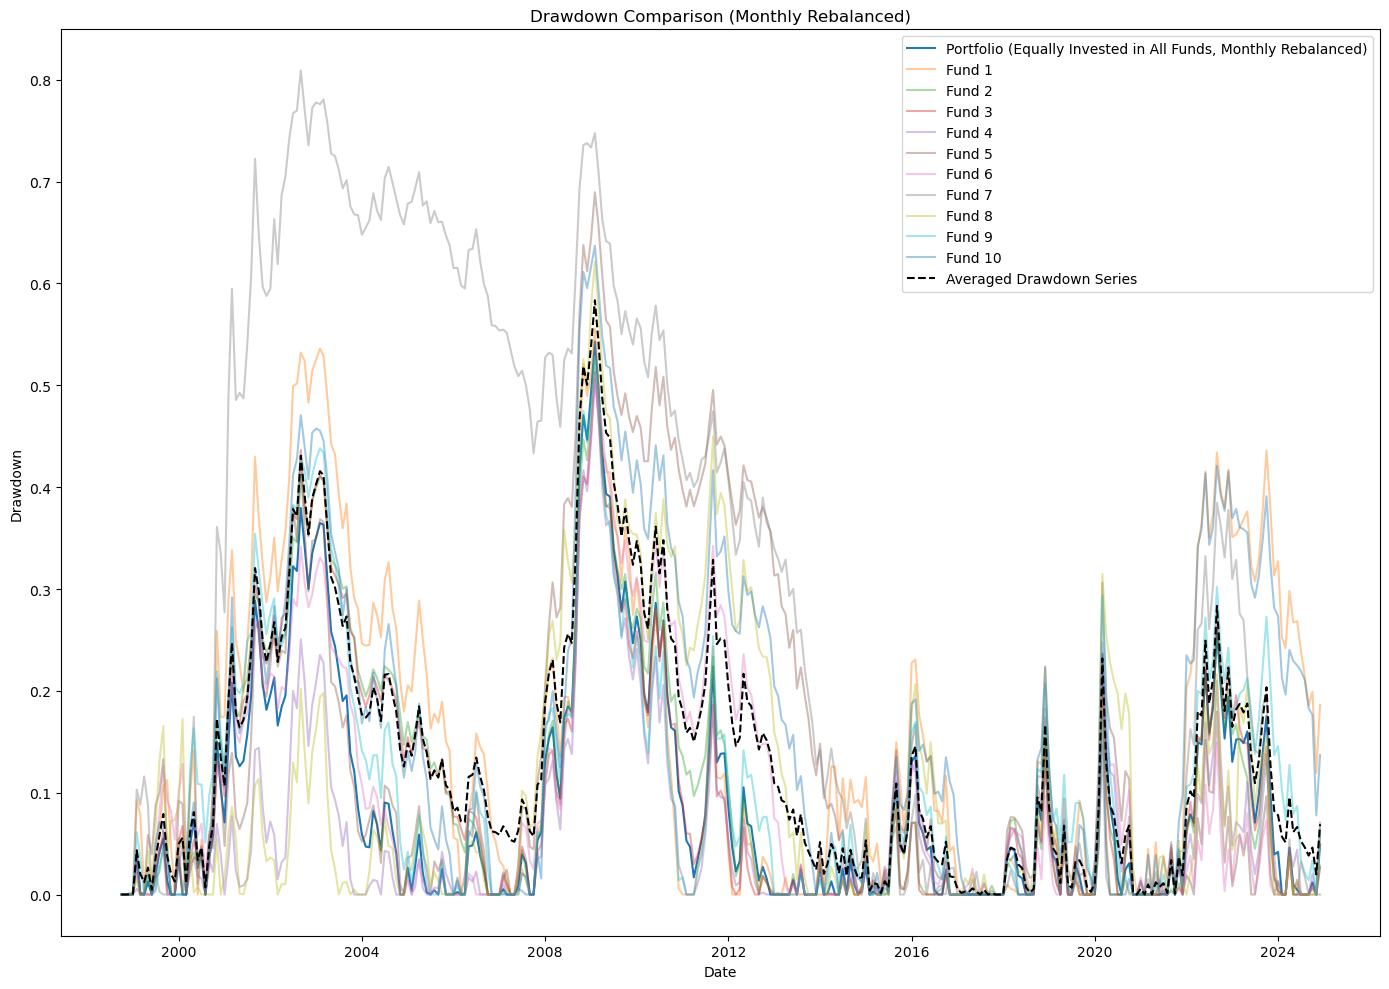

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute the drawdown
def drawdown(return_series):
    """
    Takes a time series of asset returns.
    Returns a DataFrame with columns for:
    - the price index,
    - the high water mark, and
    - the percentage drawdown.
    """
    price_index = (1 + return_series).cumprod()
    high_water_mark = price_index.cummax()
    drawdowns = (high_water_mark - price_index) / high_water_mark
    return pd.DataFrame({"Price Index": price_index,
                         "High Water Mark": high_water_mark,
                         "Drawdown": drawdowns})

# Function to compute monthly rebalanced equal-weighted portfolio returns
def equal_weighted_portfolio(returns):
    """
    Computes the returns of an equal-weighted portfolio that is rebalanced monthly.
    """
    n_funds = returns.shape[1]  # Number of funds
    equal_weights = np.ones(n_funds) / n_funds  # Equal weights
    portfolio_returns = (returns * equal_weights).sum(axis=1)  # Monthly rebalanced returns
    return portfolio_returns

# Calculate portfolio returns equally invested in all 21 funds and rebalanced monthly
portfolio_returns = equal_weighted_portfolio(combined_funds)

# Calculate drawdown for the portfolio
drawdown_portfolio = drawdown(portfolio_returns)['Drawdown']

# Calculate individual drawdown series for the 10 active funds
drawdown_active_funds = funds_net_return_time.apply(lambda x: drawdown(x)['Drawdown'], axis=0)

# Calculate averaged drawdown series by taking cross-sectional averages in every month
average_drawdown_series = drawdown_active_funds.mean(axis=1)

# Plot the drawdown series
plt.figure(figsize=(14, 10))
plt.plot(drawdown_portfolio.index.to_timestamp(), drawdown_portfolio, label='Portfolio (Equally Invested in All Funds, Monthly Rebalanced)')
for column in drawdown_active_funds.columns:
    plt.plot(drawdown_active_funds.index.to_timestamp(), drawdown_active_funds[column], alpha=0.4, label=column)
plt.plot(average_drawdown_series.index.to_timestamp(), average_drawdown_series, label='Averaged Drawdown Series', linestyle='--', color='black')

# Add labels and legend (inside the plot, upper left)
plt.title('Drawdown Comparison (Monthly Rebalanced)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend(loc='upper right')  # Place legend inside the plot, upper left corner
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The plot shows that the equally invested portfolio provides a more stable and less risky investment option compared to individual active funds. While some active funds may outperform the portfolio during certain periods, the portfolio's diversification and rebalancing helps mitigate the impact of poor performance from any single fund, resulting in a smoother and more consistent drawdown profile.

### c) Find the maximum Sharpe ratio, which an unconstrained mean-variance efficient portfolio can deliver, analytically (that is using a formula and no numerical optimization).

$$
\text{Sharpe Ratio} = \frac{\mu_{\text{e}}}{\sigma}
$$

Where:
- $ \mu_{\text{e}} $: Expected excess return of the portfolio.
- $ \sigma $: Standard deviation (volatility) of the portfolio's returns.

In [78]:
import numpy as np

# Covariance matrix 
cov_matrix = combined_funds.cov()

# Compute the inverse of the covariance matrix (Sigma^{-1})
cov_matrix_inv = np.linalg.inv(cov_matrix)

# Compute the weights of the tangency portfolio
ones = np.ones(len(mu_e))  # Vector of ones
w_tangency = (cov_matrix_inv @ mu_e) / (ones.T @ cov_matrix_inv @ mu_e)

# Compute the Sharpe ratio of the tangency portfolio
sharpe_tangency = (w_tangency.T @ mu_e) / np.sqrt(w_tangency.T @ cov_matrix @ w_tangency)

# Annualize the Sharpe ratio
sharpe_tangency_annual = sharpe_tangency * np.sqrt(12)

# Print the results
print("\nWeights of the Tangency Portfolio:")
print(np.round(w_tangency, 4))
print("\nMonthly Sharpe Ratio (Tangency Portfolio):", round(sharpe_tangency, 4))
print("Annualized Sharpe Ratio (Tangency Portfolio):", round(sharpe_tangency_annual, 4))


Weights of the Tangency Portfolio:
[-0.2983 -0.2205 -3.9011  0.1221 -0.2919 -0.4688  0.0567  0.2396  0.2819
 -0.2178  3.6358 -0.4803 -0.0203 -0.2356 -0.0483 -0.077   2.0715  0.0681
  0.6334  0.267  -0.1162]

Monthly Sharpe Ratio (Tangency Portfolio): 0.4174
Annualized Sharpe Ratio (Tangency Portfolio): 1.4461


## 2.  Now compute the portfolio weights of the tangency portfolio and of the global minimum variance portfolio using numerical optimization. Implement the following constraints: i) no-short sales and a maximum position of 10% for active funds (0 ≤ xa ≤ 0.1, for every weight xa), ii) short sale restrictions of 5% and upper bounds of 100% for passive funds (−0.05 ≤ xp ≤ 1, for every weight xp), iii) the total weight in passive indices has to be at least 50%, and iv) the combined weight in active indices has to be at least 25%.

###  a) Compute the composition of the tangency portfolio θT, the composition of the minimum variance portfolio θmin, and the efficient frontier under the constraints above.

In [81]:
# Define the active and passive funds
active_funds = ["Fund 1", "Fund 2", "Fund 3", "Fund 4", "Fund 5",
                "Fund 6", "Fund 7", "Fund 8", "Fund 9", "Fund 10"]

passive_funds = ["V500", "VExM", "VSC", "VES", "VPC", "VV", "VB",
                 "VEMS", "VMC", "VSCG", "VSCV"]

# Combine the fund names (for reference)
combined_fund_names = active_funds + passive_funds

# Define the constraints
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights equals 1
    {'type': 'ineq', 'fun': lambda weights: np.sum(weights[:len(active_funds)]) - 0.25},  # Active funds ≥ 25%
    {'type': 'ineq', 'fun': lambda weights: np.sum(weights[len(active_funds):]) - 0.5}  # Passive funds ≥ 50%
]

# Define the bounds
bounds = [(0, 0.1) if fund in active_funds else (-0.05, 1) for fund in combined_fund_names]

In [82]:
def neg_sharpe(weights, riskfree_rate, expected_returns, cov_matrix):
    """Compute the negative Sharpe ratio of the portfolio."""
    r = portfolio_return(weights, expected_returns)
    vol = portfolio_vol(weights, cov_matrix)
    return -(r - riskfree_rate) / vol

def max_sr_constrained(riskfree_rate, expected_returns, cov_matrix, constraints, bounds):
    """Find the weights of the portfolio that maximizes the Sharpe ratio."""
    n = expected_returns.shape[0]
    init_guess = np.repeat(1 / n, n)  # Equal weights as initial guess
    result = minimize(
        neg_sharpe, init_guess,
        args=(riskfree_rate, expected_returns, cov_matrix),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
        options={'disp': False}
    )
    return result.x

In [83]:
# Compute the tangency portfolio weights
w_maxsr = max_sr_constrained(rf, mu, sigma, constraints, bounds)
mu_maxSR = portfolio_return(w_maxsr, mu)
std_maxSR = portfolio_vol(w_maxsr, sigma)
maxSR = -neg_sharpe(w_maxsr, rf, mu, sigma)

In [84]:
# Display results
print("Tangency Portfolio Weights:\n", pd.Series(w_maxsr, index=combined_fund_names))
print('\nTangency Portfolio - Maximum Sharpe ratio (Monthly):')
print(f'Return: {np.round(mu_maxSR * 100, 2)}%')
print(f'Standard deviation: {np.round(std_maxSR * 100, 2)}%')
print(f'Sharpe Ratio: {np.round(maxSR, 2)}')

Tangency Portfolio Weights:
 Fund 1     4.767116e-16
Fund 2     0.000000e+00
Fund 3     2.753874e-15
Fund 4     1.000000e-01
Fund 5     4.571030e-16
Fund 6     3.633841e-16
Fund 7     5.000000e-02
Fund 8     1.000000e-01
Fund 9     5.036043e-16
Fund 10    5.496490e-16
V500      -5.000000e-02
VExM      -5.000000e-02
VSC       -5.000000e-02
VES       -5.000000e-02
VPC       -5.000000e-02
VV        -5.000000e-02
VB         9.332887e-01
VEMS      -5.000000e-02
VMC        2.667113e-01
VSCG      -5.000000e-02
VSCV      -5.000000e-02
dtype: float64

Tangency Portfolio - Maximum Sharpe ratio (Monthly):
Return: 0.7%
Standard deviation: 3.06%
Sharpe Ratio: 0.18


In [85]:

def minimize_vol_constrained(expected_returns, cov_matrix, constraints, bounds):
    """Find the weights of the portfolio with the minimum variance."""
    n = expected_returns.shape[0]
    init_guess = np.repeat(1 / n, n)  # Equal weights as initial guess
    result = minimize(
        portfolio_vol, init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
        options={'disp': False}
    )
    return result.x

def minimize_vol_target_mu_constrained(expected_returns, cov_matrix, constraints, bounds, mu_target, init_guess):
    """Find the weights of the portfolio that achieves the target return with minimum variance."""
    def er_equal_to_mu_target(weights):
        return portfolio_return(weights, expected_returns) - mu_target

    # Add the target return constraint
    constraint = [{'type': 'eq', 'fun': er_equal_to_mu_target}]
    constraint.extend(constraints)

    result = minimize(
        portfolio_vol, init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        constraints=constraint,
        bounds=bounds,
        options={'disp': False}
    )
    return result.x


# Compute the global minimum variance (GMV) portfolio weights
w_GMV = minimize_vol_constrained(mu, sigma, constraints, bounds)
mu_GMV = portfolio_return(w_GMV, mu)
std_GMV = portfolio_vol(w_GMV, sigma)

# Display results
print("\nGlobal Minimum Variance Portfolio Weights:\n", pd.Series(w_GMV, index=combined_fund_names))
print('\nMinimum Variance Portfolio (Monthly):')
print(f'Return: {np.round(mu_GMV * 100, 2)}%')
print(f'Standard deviation: {np.round(std_GMV * 100, 2)}%')



Global Minimum Variance Portfolio Weights:
 Fund 1     0.000000e+00
Fund 2     5.000000e-02
Fund 3     0.000000e+00
Fund 4     1.000000e-01
Fund 5     1.680048e-18
Fund 6     1.000000e-01
Fund 7     0.000000e+00
Fund 8     0.000000e+00
Fund 9     0.000000e+00
Fund 10    0.000000e+00
V500      -5.000000e-02
VExM      -5.000000e-02
VSC       -5.000000e-02
VES       -5.000000e-02
VPC        1.336098e-01
VV         1.639018e-02
VB         1.000000e+00
VEMS      -5.000000e-02
VMC       -5.000000e-02
VSCG      -5.000000e-02
VSCV      -5.000000e-02
dtype: float64

Minimum Variance Portfolio (Monthly):
Return: 0.53%
Standard deviation: 2.53%


In [86]:
# Compute the portfolio with the highest return in the feasible set
w_max_return = minimize_vol_target_mu_constrained(mu, sigma, constraints, bounds, mu.max(), w_GMV)
mu_max_return = portfolio_return(w_max_return, mu)  # Highest return portfolio return
std_max_return = portfolio_vol(w_max_return, sigma)  # Highest return portfolio standard deviation

# Define target returns for the efficient frontier (from GMV to highest return portfolio)
mu_target = np.linspace(mu_GMV, mu_max_return, 50)  # 50 points between GMV and highest return portfolio

# Compute the efficient frontier using warm start
init_guess = w_GMV  # Start from the GMV portfolio
w_frontier = []
for m in mu_target:
    result = minimize_vol_target_mu_constrained(mu, sigma, constraints, bounds, m, init_guess)
    w_frontier.append(result)
    init_guess = result  # Warm start: use the result as the initial guess for the next optimization

# Compute the returns and standard deviations for the efficient frontier
mu_frontier = [portfolio_return(w, mu) for w in w_frontier]  # Monthly returns
std_frontier = [portfolio_vol(w, sigma) for w in w_frontier]  # Monthly standard deviations


In [87]:
mu_frontier_array = np.array(mu_frontier)
mu_frontier_a = mu_frontier_array * 12 * 100

In [88]:
std_frontier_array = np.array(std_frontier)
std_frontier_a = std_frontier_array * np.sqrt(12) * 100

### b) Plot your results (µT & σT, µmin & σmin, µ & σ of all risky assets) in a mean-standard deviation plane. For plotting, annualize means and standard deviations by simply multiplying means by 12 and standard deviations by √12.

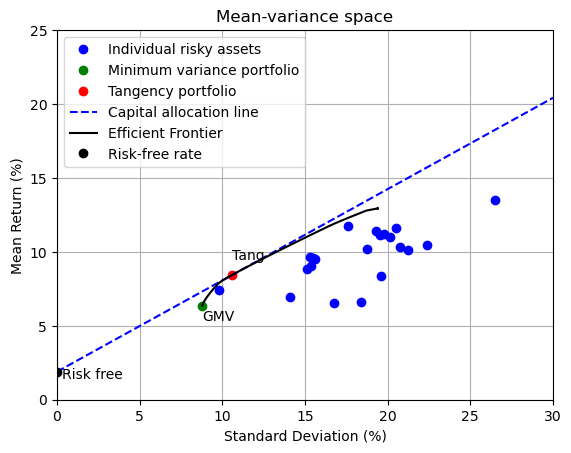

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute monthly expected returns, covariance matrix, and standard deviations
mu = combined_funds.mean()  # Monthly expected returns
sigma = combined_funds.cov()  # Monthly covariance matrix
stdv = combined_funds.std()  # Monthly standard deviations for each asset

# Compute annualized means and standard deviations for all risky assets
mu_a = mu * 12  # Annualized expected returns
stdv_a = stdv * np.sqrt(12)  # Annualized standard deviations

# Annualize the GMV portfolio returns and standard deviation
mu_GMV_a = mu_GMV * 12  # Annualized GMV portfolio return
std_GMV_a = std_GMV * np.sqrt(12)  # Annualized GMV portfolio standard deviation

# Annualize the tangency portfolio returns and standard deviation
mu_maxSR_a = mu_maxSR * 12  # Annualized tangency portfolio return
std_maxSR_a = std_maxSR * np.sqrt(12)  # Annualized tangency portfolio standard deviation

# Annualize the risk-free rate
rf_a = rf * 12  # Annualized risk-free rate

# Define the Capital Allocation Line (CAL)
def CAL(rf, sharpe_ratio, std):
    """Compute the Capital Allocation Line."""
    return rf + sharpe_ratio * std

# Compute the Sharpe ratio of the tangency portfolio
sharpe_ratio_tangency = (mu_maxSR_a - rf_a) / std_maxSR_a

# Compute the efficient frontier
mu_target = np.linspace(mu_GMV, mu.max(), 50)  # Target returns (monthly)
init_guess = w_GMV  # Start from the GMV portfolio
w_frontier = []
for m in mu_target:
    result = minimize_vol_target_mu_constrained(mu, sigma, constraints, bounds, m, init_guess)
    w_frontier.append(result)
    init_guess = result  # Warm start: use the result as the initial guess for the next optimization

# Compute the returns and standard deviations for the efficient frontier
mu_frontier = [portfolio_return(w, mu) for w in w_frontier]  # Monthly returns
std_frontier = [portfolio_vol(w, sigma) for w in w_frontier]  # Monthly standard deviations

# Annualize the efficient frontier
mu_frontier_a = np.array(mu_frontier) * 12  # Annualized efficient frontier returns
std_frontier_a = np.array(std_frontier) * np.sqrt(12)  # Annualized efficient frontier standard deviations

# Plotting the individual risky assets
plt.plot(stdv_a * 100, mu_a * 100, "bo", label='Individual risky assets')

# Plot GMV Portfolio
plt.plot(std_GMV_a * 100, mu_GMV_a * 100, "go", label='Minimum variance portfolio')
plt.annotate("GMV", (std_GMV_a * 100, mu_GMV_a * 100 - 1))

# Plot Tangency Portfolio
plt.plot(std_maxSR_a * 100, mu_maxSR_a * 100, "ro", label='Tangency portfolio')
plt.annotate("Tang", (std_maxSR_a * 100, mu_maxSR_a * 100 + 1))

# Plotting the Capital Allocation Line (CAL)
plt.plot(np.arange(0, 30.1, 0.1), CAL(rf_a, sharpe_ratio_tangency, np.arange(0, 30.1, 0.1) / 100) * 100, 'b--', label='Capital allocation line')

# Plotting the Efficient Frontier (constrained)
plt.plot(std_frontier_a * 100, mu_frontier_a * 100, "k-", label='Efficient Frontier')

# Plotting the risk-free rate
plt.plot(0, rf_a * 100, "ko", label='Risk-free rate')
plt.annotate("Risk free", (0 + 0.3, rf_a * 100 - 0.5))

# Legend and labels
plt.legend(loc='upper left')
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Mean Return (%)")
plt.title("Mean-variance space")
plt.grid("on")
plt.axis([0, 30, 0, 25])
plt.show()

In [91]:
# Print individual risky assets
print("Individual Risky Assets:")
for fund, mu, std in zip(combined_funds.columns, mu_a, stdv_a):
    print(f"{fund}: Expected Return = {np.round(mu * 100, 2)}%, Standard Deviation = {np.round(std * 100, 2)}%")

# Print GMV Portfolio
print("\nGMV Portfolio:")
print(f"Expected Return = {np.round(mu_GMV_a * 100, 2)}%, Standard Deviation = {np.round(std_GMV_a * 100, 2)}%")

# Print Tangency Portfolio
print("\nTangency Portfolio:")
print(f"Expected Return = {np.round(mu_maxSR_a * 100, 2)}%, Standard Deviation = {np.round(std_maxSR_a * 100, 2)}%")
print(f"Sharpe Ratio = {np.round(sharpe_ratio_tangency, 2)}")

# Print Risk-Free Rate
print("\nRisk-Free Rate:")
print(f"Expected Return = {np.round(rf_a * 100, 2)}%, Standard Deviation = 0%")


Individual Risky Assets:
Fund 1: Expected Return = 10.46%, Standard Deviation = 22.39%
Fund 2: Expected Return = 8.83%, Standard Deviation = 15.12%
Fund 3: Expected Return = 9.53%, Standard Deviation = 15.58%
Fund 4: Expected Return = 9.61%, Standard Deviation = 15.47%
Fund 5: Expected Return = 8.34%, Standard Deviation = 19.61%
Fund 6: Expected Return = 6.94%, Standard Deviation = 14.07%
Fund 7: Expected Return = 13.53%, Standard Deviation = 26.48%
Fund 8: Expected Return = 11.13%, Standard Deviation = 19.51%
Fund 9: Expected Return = 10.17%, Standard Deviation = 18.77%
Fund 10: Expected Return = 10.33%, Standard Deviation = 20.75%
V500: Expected Return = 9.63%, Standard Deviation = 15.29%
VExM: Expected Return = 10.98%, Standard Deviation = 20.11%
VSC: Expected Return = 11.22%, Standard Deviation = 19.78%
VES: Expected Return = 6.61%, Standard Deviation = 18.4%
VPC: Expected Return = 6.58%, Standard Deviation = 16.74%
VV: Expected Return = 9.06%, Standard Deviation = 15.34%
VB: Expec

## 3. Back-test the performance of the constrained minimum variance portfolio θmin, an equally weighted portfolio with equal weights in all N assets, and a portfolio with weights determined by the inverse of a fund’s variance.5 That is, the weight in fund i in month t is equal to (1/σ2 i,t)/( N n 1/σ2 n,t). Use an estimation window of 60 months. Rebalance the portfolios every month.

### a) Plot cumulative returns for each strategy against time.

In [94]:
def weight_gmv(r):
    """
    Calculate weights for the global minimum variance portfolio.
    """
    cov = r.cov()
    n = cov.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = ((0, 1),) * n  # No short sales
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    result = minimize(
        lambda weights: portfolio_vol(weights, cov),
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x

def weight_ew(r):
    """
    Calculate equal weights for all assets.
    """
    n = r.shape[1]
    return np.repeat(1 / n, n)

def weight_inverse_variance(r):
    """
    Calculate weights based on the inverse of each fund's variance.
    """
    variances = r.var()
    inv_var = 1 / variances
    weights = inv_var / inv_var.sum()
    return weights

In [95]:
# Backtest the constrained minimum variance portfolio
r_gmv_bt, w_gmv_bt = backtest_ws(combined_funds, weighting=weight_gmv, estimation_window=60)

# Backtest the equally-weighted portfolio
r_ew_bt, w_ew_bt = backtest_ws(combined_funds, weighting=weight_ew, estimation_window=60)

# Backtest the inverse-variance-weighted portfolio
r_inv_var_bt, w_inv_var_bt = backtest_ws(combined_funds, weighting=weight_inverse_variance, estimation_window=60)

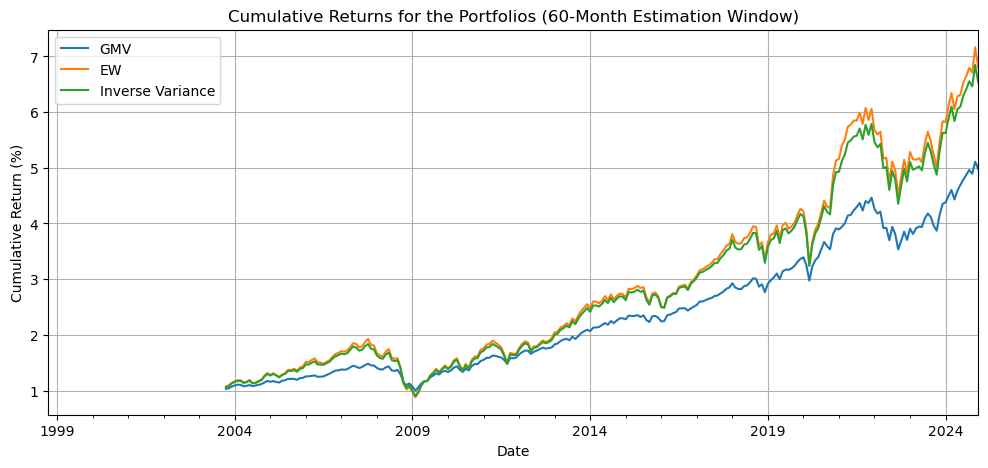

In [96]:
# Combine the results into a DataFrame
btr = pd.DataFrame({
    "GMV": r_gmv_bt,
    "EW": r_ew_bt,
    "Inverse Variance": r_inv_var_bt
})

# Plot cumulative returns
(1 + btr).cumprod().plot(figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Cumulative Returns for the Portfolios (60-Month Estimation Window)")
plt.grid("on")
plt.show()

### b. Report annualized returns, standard deviations, and Sharpe ratios as well as measures of downside risk. Take the effect of compounding into account when annualizing returns. Comment on the performance.

In [98]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes the mean return for a series of provided returns
    and a given number of periods per year.
    """
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth ** (periods_per_year / n_periods) - 1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the volatility of a series of provided returns
    and a given number of periods per year.
    """
    return r.std() * (periods_per_year ** 0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized Sharpe ratio of a set of returns.
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1 + riskfree_rate) ** (1 / periods_per_year) - 1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret / ann_vol

def drawdown(returns):
    """
    Compute the drawdown of a return series.
    """
    wealth_index = (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
    })

def summary_stats_extended(r, riskfree_rate, periods_per_year):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r.
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year) * 100
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year) * 100
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(lambda r: scipy.stats.skew(r))
    kurt = r.aggregate(lambda r: scipy.stats.kurtosis(r))
    return pd.DataFrame({
        "Annualized Return (%)": ann_r,
        "Annualized Vol (%)": ann_vol,
        "Sharpe Ratio": ann_sr,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Max Drawdown": dd
    })

In [99]:
# Combine the backtested returns into a DataFrame
btr = pd.DataFrame({
    "GMV": r_gmv_bt,
    "EW": r_ew_bt,
    "Inverse Variance": r_inv_var_bt
})

# Calculate summary statistics
summary_stats = summary_stats_extended(btr.dropna(), rf_a, 12)
print("Summary Statistics for Cumulative Returns (60-Month Estimation Window):")
summary_stats


Summary Statistics for Cumulative Returns (60-Month Estimation Window):


,Annualized Return (%),Annualized Vol (%),Sharpe Ratio,Skewness,Kurtosis,Max Drawdown
GMV,7.848930,9.628544,0.607526,-0.647568,1.853127,-0.325749
EW,9.448595,16.193324,0.458250,-0.660617,1.929376,-0.543018
Inverse Variance,9.238422,14.975045,0.481756,-0.661306,1.848721,-0.509975


**Minimum Variance Portfolio (GMV)**

The GMV portfolio has the lowest annualized return among the three portfolios, which is expected since it prioritizes risk minimization over maximizing returns. It also has the lowest volatility (9.63%), making it the least risky portfolio. This is reflected in its highest Sharpe ratio (0.61), indicating the best risk-adjusted performance. The negative skewness (-0.65) suggests that the portfolio is more likely to experience negative returns than positive ones, but the low kurtosis (1.85) indicates that extreme returns (both positive and negative) are less likely. The maximum drawdown of -32.57% is the smallest among the three portfolios, highlighting its resilience during market downturns.

**Equally Weighted Portfolio (EW)**

The EW portfolio has the highest annualized return (9.45%) but also the highest volatility (16.19%), making it the riskiest portfolio. Its Sharpe ratio (0.46) is the lowest among the three portfolios, indicating poorer risk-adjusted performance compared to the GMV and Inverse Variance portfolios. The negative skewness (-0.66) and higher kurtosis (1.93) suggest a higher likelihood of extreme negative returns, which is consistent with its largest maximum drawdown (-54.30%).

**Equally Weighted Portfolio (EW)**

The EW portfolio has the highest annualized return (9.45%) but also the highest volatility (16.19%), making it the riskiest portfolio. Its Sharpe ratio (0.46) is the lowest among the three portfolios, indicating poorer risk-adjusted performance compared to the GMV and Inverse Variance portfolios. The negative skewness (-0.66) and higher kurtosis (1.93) suggest a higher likelihood of extreme negative returns, which is consistent with its largest maximum drawdown (-54.30%).

## 4. A fund manager reveals that her portfolio ignores the fund Vanguard Balanced Index, among others. “We require a high target return and the expected return of this fund is below our threshold of 8% p.a.,” is her reasoning. Consider the same constraints as in part 2. above.

### a) Why is this reasoning flawed? Explain how to find an optimal portfolio given an investment universe.

The fund manager's reasoning is flawed because excluding assets based solely on their expected returns ignores the importance of diversification and the risk-return trade-off in portfolio optimization. Even if an asset (e.g., Vanguard Balanced Index) has a lower expected return, it might contribute to reducing overall portfolio risk through diversification. By excluding such assets, the manager might miss out on the benefits of risk reduction, which could lead to a suboptimal portfolio. Also, the performance of an asset in a portfolio depends not only on its expected return but also on its correlation with other assets. An asset with a lower expected return but low or negative correlation with other assets can improve the portfolio's risk-adjusted returns (e.g., Sharpe ratio).
The goal of portfolio optimization is to find the efficient frontier, which represents the set of portfolios that offer the highest expected return for a given level of risk. Excluding assets based on arbitrary thresholds (e.g., 8% p.a.) can prevent the portfolio from lying on the efficient frontier.

To find an optimal portfolio given an investment universe, first it's necessary to define the Investment Universe: Include all available assets (e.g., active funds, passive funds, Vanguard Balanced Index) in the investment universe and ensure that the data (e.g., expected returns, covariance matrix) is accurate and up-to-date.

Then it's necessary to set the constraints (which will be the ones used in exercise 2):

Active funds: ≥ 25% allocation, no short sales, maximum 10% per fund.

Passive funds: ≥ 50% allocation, short sales allowed up to 5%, maximum 100% per fund.

Next, to optimize the Portfolio use mean-variance optimization to find the optimal portfolio weights that maximize the Sharpe ratio (risk-adjusted return) or minimize volatility for a given target return. The optimization problem can be formulated as:

Maximize: Sharpe ratio = (Expected portfolio return - Risk-free rate) / Portfolio volatility

Subject to: Constraints on weights (e.g., no short sales, minimum/maximum allocations).

Afterwards, compute the efficient frontier by solving the optimization problem for a range of target returns and, lastly, select the Optimal Portfolio which will be the one that best aligns with the investor's risk tolerance and return objectives.

### b. Compute the composition of the tangency portfolio when ignoring all funds with µi < 8% and compare this to θT, which you computed above. What is the Sharpe ratio loss from restricting the investment universe?

In [107]:
# Filter funds with average yearly expected returns >= 8%
high_return_funds = combined_funds.loc[:, mu_a >= 0.08]

# Print the list of funds with expected returns >= 8%
print("Funds with Expected Returns >= 8%:")
print(high_return_funds.columns.tolist())

# Compute monthly returns and covariance matrix for the restricted universe
mu_high = high_return_funds.mean()  # Monthly mean returns
sigma_high = high_return_funds.cov()  # Monthly covariance matrix

# Define bounds for the restricted universe (monthly data)
bounds_restricted_monthly = [(0, 0.1) if fund in active_funds else (-0.05, 1) for fund in high_return_funds.columns]

# Define active_funds_restricted
active_funds_restricted = [fund for fund in active_funds if fund in high_return_funds.columns]

# Define constraints for the restricted universe (monthly data)
constraints_restricted_monthly = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights equals 1
    {'type': 'ineq', 'fun': lambda weights: np.sum(weights[:len(active_funds_restricted)]) - 0.25},  # Active funds ≥ 25%
    {'type': 'ineq', 'fun': lambda weights: np.sum(weights[len(active_funds_restricted):]) - 0.5}  # Passive funds ≥ 50%
]

# Compute the tangency portfolio for the restricted universe (monthly data)
w_maxsr_high = max_sr_constrained(rf, mu_high, sigma_high, constraints_restricted_monthly, bounds_restricted_monthly)

# Compute portfolio metrics (monthly data)
mu_maxSR_high = portfolio_return(w_maxsr_high, mu_high)  # Monthly portfolio return
std_maxSR_high = portfolio_vol(w_maxsr_high, sigma_high)  # Monthly portfolio volatility
maxSR_high_monthly = -neg_sharpe(w_maxsr_high, rf, mu_high, sigma_high)  # Monthly Sharpe ratio

# Annualize the metrics
mu_maxSR_high_a = mu_maxSR_high * 12  # Annualized portfolio return
std_maxSR_high_a = std_maxSR_high * np.sqrt(12)  # Annualized portfolio volatility
maxSR_high_a = maxSR_high_monthly * np.sqrt(12)  # Annualized Sharpe ratio

# Print the annualized metrics
print("\nAnnualized Tangency Portfolio Metrics:")
print(f"Expected Return: {np.round(mu_maxSR_high_a * 100, 2)}%")
print(f"Standard Deviation: {np.round(std_maxSR_high_a * 100, 2)}%")
print(f"Sharpe Ratio: {np.round(maxSR_high_a, 2)}")

Funds with Expected Returns >= 8%:
['Fund 1', 'Fund 2', 'Fund 3', 'Fund 4', 'Fund 5', 'Fund 7', 'Fund 8', 'Fund 9', 'Fund 10', 'V500', 'VExM', 'VSC', 'VV', 'VEMS', 'VMC', 'VSCG', 'VSCV']

Annualized Tangency Portfolio Metrics:
Expected Return: 12.0%
Standard Deviation: 17.62%
Sharpe Ratio: 0.57


In [108]:
# Calculate Sharpe ratio loss
sharpe_ratio_loss = sharpe_ratio_tangency - maxSR_high_a
print(f'Sharpe Ratio Loss from Restricting the Investment Universe: {np.round(sharpe_ratio_loss, 2)}')

Sharpe Ratio Loss from Restricting the Investment Universe: 0.04


### c. The fund manager’s portfolio has a target expected return of 10%. In the optimal portfolio with this target return, what are the positions in funds excluded by the fund manager?

In [110]:
mu=combined_funds.mean()
# Define the target return in monthly terms
target_return_monthly = 0.10 / 12  # 10% annual target return converted to monthly

# Identify excluded funds (funds with annualized expected returns < 8%)
excluded_funds = combined_funds.columns[mu_a < 0.08]

# Define bounds to enforce zero weights for excluded funds
bounds = [(0, 0) if fund in excluded_funds else (0, 1) for fund in combined_funds.columns]

# Compute the optimal portfolio weights for the target return (monthly data)
# Use mu and sigma for the full universe
w_target = minimize_vol_target_mu_constrained(mu, sigma, constraints, bounds, target_return_monthly, w_maxsr)

# Ensure weights is a 1-D array
w_target = np.array(w_target).flatten()

# Compute the portfolio return and standard deviation (monthly data)
mu_target = portfolio_return(w_target, mu)
std_target = portfolio_vol(w_target, sigma)

# Annualize the portfolio return and standard deviation
mu_target_annual = mu_target * 12
std_target_annual = std_target * np.sqrt(12)

# Display results
print("Optimal Portfolio Weights (Target Return = 10% Annualized):\n", pd.Series(w_target, index=combined_funds.columns))
print(f'Annualized Portfolio Return: {np.round(mu_target_annual * 100, 2)}%')
print(f'Annualized Portfolio Standard Deviation: {np.round(std_target_annual * 100, 2)}%')

# Extract positions in excluded funds
positions_excluded = pd.Series(w_target, index=combined_funds.columns)[excluded_funds]

# Display positions in excluded funds
print("\nPositions in Excluded Funds:")
print(positions_excluded)

Optimal Portfolio Weights (Target Return = 10% Annualized):
 Fund 1     0.000000e+00
Fund 2     0.000000e+00
Fund 3     0.000000e+00
Fund 4     2.685933e-01
Fund 5     6.839748e-17
Fund 6     0.000000e+00
Fund 7     0.000000e+00
Fund 8     1.467170e-17
Fund 9     7.864545e-18
Fund 10    6.505183e-18
V500       3.620126e-01
VExM       8.853745e-18
VSC        7.935939e-18
VES        0.000000e+00
VPC        0.000000e+00
VV         1.524466e-01
VB         0.000000e+00
VEMS       1.453245e-17
VMC        2.169475e-01
VSCG       1.539719e-17
VSCV       7.726721e-18
dtype: float64
Annualized Portfolio Return: 10.0%
Annualized Portfolio Standard Deviation: 15.46%

Positions in Excluded Funds:
Fund 6    0.0
VES       0.0
VPC       0.0
VB        0.0
dtype: float64


# Exercise 3

- Import Libraries

In [113]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statistics

- Load Data

In [115]:
# Load the data
data = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "buffetts_alpha_data", header=0, index_col=0)
# Set date index to montly
data.index = pd.to_datetime(data.index, format="%Y%m%d").to_period('D')

In [116]:
# Rename the columns
data = data.rename(columns={'Berkshire Hathaway, total return': 'r_brk',
                                 'Public stocks from 13F, total return': 'r_brkp',
                                 'Heinz, total return': 'r_hnz',
                                 'Lubrizol, total return': 'r_lz',
                                 'MKT (excess return)': 'MKT'})

data["MktRf"] = data["MKT"] - data['rf']

data.columns

Index(['r_brk', 'r_brkp', 'r_lz', 'r_hnz', 'rf', 'MKT', 'SMB', 'HML', 'QMJ',
       'BAB', 'UMD', 'MktRf'],
      dtype='object')

### Question 1 & Question 2
Compute the factor loadings and annualized alpha of Berkshire Hathaway & Berkshire Hathaway 13F 
with respect to the following factor models and interpret the results:
- a. The CAPM.
- b. The Fama-French 3-factor model with SMB and HML.
- c. The 5-factor model consisting of the FF3-factor model augmented with BAB and QMJ.

##### The CAPM Berkshire Hathaway

In [119]:
data_r_brk = data.dropna(subset='r_brk')

In [120]:
# Factor means
mu =data_r_brk['r_brk'].mean()
rf = data_r_brk['rf'].mean()
mue = data_r_brk.mean()-rf
MktRf = data_r_brk['MktRf'].mean()
MKT = data_r_brk['MKT'].mean()
SMB = data_r_brk['SMB'].mean()
HML = data_r_brk['HML'].mean()
QMJ = data_r_brk['QMJ'].mean()
BAB = data_r_brk['BAB'].mean()
UMD = data_r_brk['UMD'].mean()

In [121]:
# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm

In [122]:
# Regression for BRK Portfolio
formula = "r_brk ~ 1 + MktRf"

BHat, StdB, tstat, pval, lm = reg(formula, data_r_brk)

# Results:
alpha_monthly = BHat[0]
market_beta = BHat[1]
p_val_alpha = pval[0]
p_val_beta = pval[1]
r_squared = lm.rsquared

# Calculate key metrics
rf_mean = rf
market_premium_mean = MktRf
portfolio_mean_return = mu

# Annualize returns
alpha_annualized = (1 + alpha_monthly) ** 12 -1
expected_return_monthly = rf_mean + market_beta * market_premium_mean
expected_return_annual = (1 + expected_return_monthly) ** 12 - 1
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1

print("\nCAPM Analysis for Berkshire Hathaway:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha (Monthly)':<35}{alpha_monthly:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized)':<35}{alpha_annualized:.4f}{'':>15}") 
print(f"{'Beta':<35}{market_beta:.4f}{p_val_beta:>15.4f}")
print(f"{'Expected Return (Annualized)':<35}{expected_return_annual:.4f} ({expected_return_annual*100:.2f}%)")
print(f"{'Actual Return (Annualized)':<35}{actual_return_annual:.4f} ({actual_return_annual*100:.2f}%)")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  # No p-value for R-squared
print("=" * 70)




CAPM Analysis for Berkshire Hathaway:
Factor                             Coefficient    p-value
Alpha (Monthly)                    0.0176         0.0000
Alpha (Annualized)                 0.2335               
Beta                               0.6662         0.0000
Expected Return (Annualized)       0.0676 (6.76%)
Actual Return (Annualized)         0.2580 (25.80%)
R-squared                          0.1882               


**1a. The CAPM.**

Running the calculations through the CAPM model for Berkshire Hathaway, we got a beta of 0.6662. If the market moves up by 1%, Berkshire Hathaway is expected to move up by 0.6662%, on average. This means it has lower sensitivity to market movements, and by this we may conclude that it is less volatile and more stable during market fluctuations, and thus it’s less risky. Additionally, we got an annualized alpha value of 0.2335, which suggests that Berkshire significantly outperformed the expected returns predicted by CAPM of 6.76% by 23.35%. As the p-value is 0.00 we may infer that this result is highly statistically significant. Furthermore, this is confirmed when we look at the Expected Return according to CAPM which was 6.76%, and the actual return of Berkshire which was 25.80%. Finally, and looking at the R-squared value of 0.1882, we may predict that other factors, beyond market exposure, play a significant role in driving the company’s returns. 

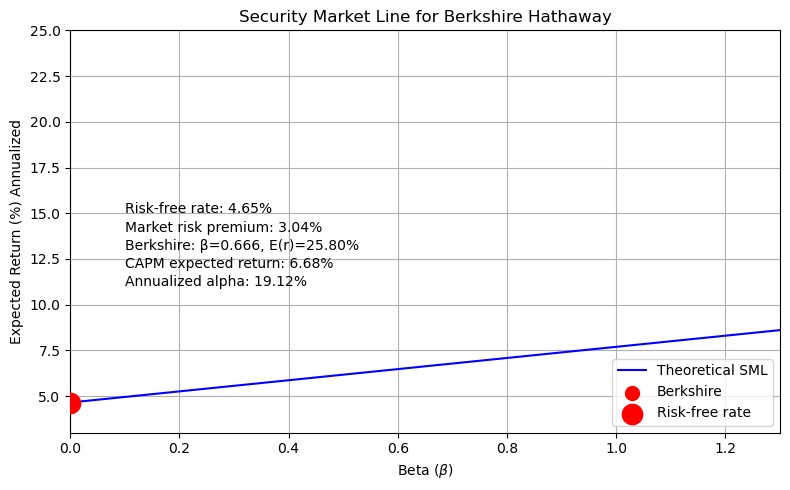

In [124]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML
beta_values = np.linspace(0, 2.0, 100)
sml_values = ((1 + rf_mean) ** 12 - 1 + beta_values * ((1 + MktRf) ** 12 - 1)) * 100  #  CAPM annualization

# Plot the theoretical SML
plt.plot(beta_values, sml_values, 'b-', label="Theoretical SML")

# Ensure consistency between calculation and plot
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1  # Consistent with regression

# Plot Berkshire (Berkshire Portfolio)
plt.scatter(market_beta, actual_return_annual * 100, s=100, color='red', label="Berkshire")
plt.annotate('Berkshire', (market_beta + 0.03, actual_return_annual * 100), fontsize=10)

#  Risk-Free Rate Annualization
rf_annualized = ((1 + rf_mean) ** 12 - 1) * 100  
plt.scatter(0, rf_annualized, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate")

# Set axis limits and labels
plt.axis([0, 1.3, 3, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Return (%) Annualized')
plt.title('Security Market Line for Berkshire Hathaway')

# Add legend
plt.legend(loc='lower right')

# Calculate CAPM expected return for Berkshire (consistent with regression)
expected_return_annual = (1 + rf_mean) ** 12 - 1 + market_beta * ((1 + MktRf) ** 12 - 1)  #  compounding
alpha_annualized = actual_return_annual - expected_return_annual  # Alpha calculation

# Add text information on the plot (improved formatting)
plt.text(0.1, 15, f"Risk-free rate: {rf_annualized:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Market risk premium: {((1 + MktRf) ** 12 - 1) * 100:.2f}%", fontsize=10)
plt.text(0.1, 13, f"Berkshire: β={market_beta:.3f}, E(r)={actual_return_annual * 100:.2f}%", fontsize=10)
plt.text(0.1, 12, f"CAPM expected return: {expected_return_annual * 100:.2f}%", fontsize=10)
plt.text(0.1, 11, f"Annualized alpha: {alpha_annualized * 100:.2f}%", fontsize=10)

plt.tight_layout()
plt.show()


#### Question 1.b
The Fama-French 3-factor model with SMB and HML. - Berkshire Hathaway

In [126]:
# Fama-French 3-Factor Model Regression for r_brk Portfolio
formula = "r_brk ~ 1 + MktRf + SMB + HML"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_brk)

# Extract regression coefficients
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]

# Extract p-values
p_val_alpha = pval[0]
p_val_betaM = pval[1]
p_val_bSMB = pval[2]
p_val_bHML = pval[3]
r_squared = lm.rsquared

# Compute predicted expected return (annualized, in percentage)
SMB_mean = data_r_brk["SMB"].mean()
HML_mean = data_r_brk["HML"].mean()

predicted_return = (betaM * MktRf + bSMB * SMB_mean + bHML * HML_mean) * 12 * 100
actual_return = (data_r_brk["r_brk"].mean() - rf_mean) * 12 * 100  # annualized excess return
alpha_annualized = alpha * 12 * 100  # Convert alpha to annualized percentage

# Print regression results in a structured format
print("\nFama-French 3-Factor Model Results:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha (Monthly)':<35}{alpha:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized) in %':<35}{alpha_annualized:.4f}{'':>15}")
print(f"{'Market Beta (β_M)':<35}{betaM:.4f}{p_val_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<35}{bSMB:.4f}{p_val_bSMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<35}{bHML:.4f}{p_val_bHML:>15.4f}")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  # No p-value for R-squared
print("=" * 70)




Fama-French 3-Factor Model Results:
Factor                             Coefficient    p-value
Alpha (Monthly)                    0.0166         0.0000
Alpha (Annualized) in %            19.9463               
Market Beta (β_M)                  0.7962         0.0000
SMB Beta (β_SMB)                   -0.2841         0.0027
HML Beta (β_HML)                   0.4521         0.0000
R-squared                          0.2456               


**1b. The Fama-French 3-factor model with SMB and HML.**

Using now the Fama-French 3-factor model, which adjusts returns for size (SMB) and value (HML) effects, we got a market beta of 0.7962, which is higher than the one calculated though CAPM, suggesting that size and value factors impact Berkshire returns.  Additionally, we also calculated the SMB beta and the HML beta. The SMB beta is -0.2841 and, since it’s negative, we may predict that Berkshire behaves like a large-cap stock. As for the HML beta, which is 0.4521, it reflects a tendency towards value stocks, which have higher book-to-market ratios. Finally, analyzing the annualized alpha value, we can conclude Berkshire Hathaway’s ability to achieve significant excess returns beyond what is explained by the market, size, and value factors. It outperforms the model’s prediction by 19.95% annually. The p-value for all these results is below 1%, suggesting statistically significancy. 

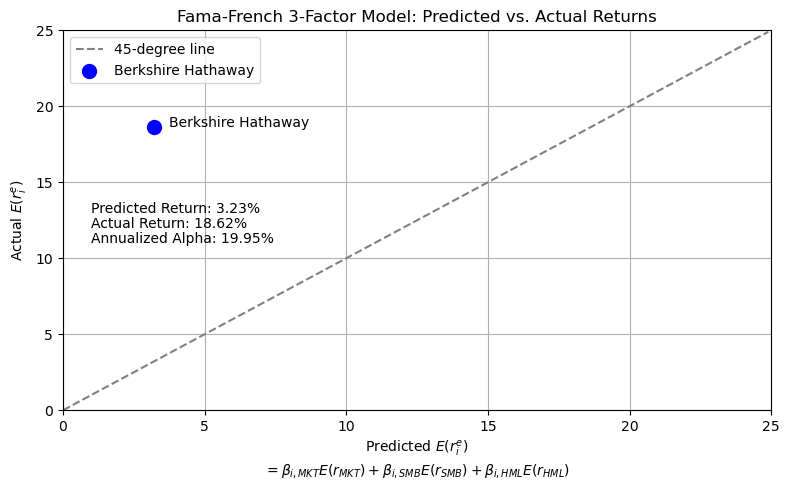

In [128]:
# Generate x = y reference line
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0, 25, 0.1), np.arange(0, 25, 0.1), linestyle='dashed', color='gray', label="45-degree line")

# Plot Berkshire Hathaway's actual vs. predicted return
plt.scatter(predicted_return, actual_return, color='blue', s=100, label='Berkshire Hathaway')
plt.annotate("Berkshire Hathaway", (predicted_return + 0.5, actual_return), fontsize=10)

# Add text annotations with key metrics
plt.text(1, 12, f"Actual Return: {actual_return:.2f}%", fontsize=10)
plt.text(1, 13, f"Predicted Return: {predicted_return:.2f}%", fontsize=10)
plt.text(1, 11, f"Annualized Alpha: {alpha_annualized:.2f}%", fontsize=10)

# Set plot properties
plt.axis([0, 25, 0, 25])
plt.grid(True)
plt.xlabel(r'Predicted $E(r_i^e)$'"\n"r'$=\beta_{i,MKT}E(r_{MKT}) + \beta_{i,SMB}E(r_{SMB}) + \beta_{i,HML}E(r_{HML})$')
plt.ylabel(r'Actual $E(r_i^e)$')
plt.title("Fama-French 3-Factor Model: Predicted vs. Actual Returns")
plt.legend()
plt.tight_layout()
plt.show()

#### Question 1.c
The 5-factor model consisting of the FF3-factor model augmented with BAB and QMJ.

In [130]:
# Run Regression for r_brk Portfolio
formula = "r_brk ~ 1 + MktRf + SMB + HML + QMJ + BAB"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_brk)

# Extract Regression Outputs
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]
bQMJ = BHat[4]
bBAB = BHat[5]

# Extract p-values
p_val_alpha = pval[0]
p_val_betaM = pval[1]
p_val_bSMB = pval[2]
p_val_bHML = pval[3]
p_val_bQMJ = pval[4]
p_val_bBAB = pval[5]
r_squared = lm.rsquared

# Print Results
print("\nOLS Regression Results:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha':<35}{alpha:.4f}{p_val_alpha:>15.4f}")
print(f"{'Market Beta (β_M)':<35}{betaM:.4f}{p_val_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<35}{bSMB:.4f}{p_val_bSMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<35}{bHML:.4f}{p_val_bHML:>15.4f}")
print(f"{'QMJ Beta (β_QMJ)':<35}{bQMJ:.4f}{p_val_bQMJ:>15.4f}")
print(f"{'BAB Beta (β_BAB)':<35}{bBAB:.4f}{p_val_bBAB:>15.4f}")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}") 
print("=" * 70)




OLS Regression Results:
Factor                             Coefficient    p-value
Alpha                              0.0119         0.0000
Market Beta (β_M)                  0.9292         0.0000
SMB Beta (β_SMB)                   -0.1421         0.1857
HML Beta (β_HML)                   0.4221         0.0001
QMJ Beta (β_QMJ)                   0.4275         0.0048
BAB Beta (β_BAB)                   0.2473         0.0041
R-squared                          0.2798               


**1c. The 5-factor model consisting of the FF3-factor model augmented with BAB and QMJ.**

Finally, we used the 5-factor model, which adds two more factors’ effects to the previous model. Firstly, the BAB factor, which captures the tendency of low-risk stocks to outperform high-risk stocks on a risk-adjusted basis. Secondly, the QMJ factor, which reflects the premium associated with high-quality firms. The betas for these factors are 0.2473 and 0.4275, respectively. The fact that both are positive reflects that on one side Berkshire prefers less volatile and safer stocks, and on the other, high-quality stocks with robust profitability and stable earnings. As for SMB and HML betas, the interpretation remains the same as they didn’t have significant changes. The market beta is now 0.9292, closer to 1, which means that Berkshire is moving more in line with the market compared to the other models. Finally, alpha decreased its value to, approximately, 14.3%, which means that Berkshire still generates excess returns beyond what the model predicts but these are lower than in the 3-factor model. Since p-value is 0.0000, it’s still statistically significant suggesting that Berkshire consistently generates abnormal returns.

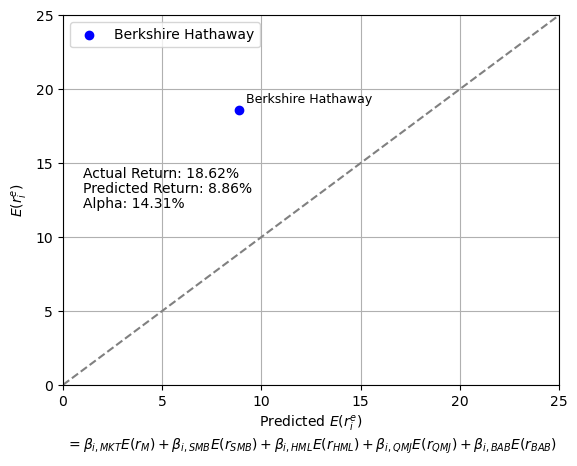

In [132]:
# Generate x = y Reference Line
plt.plot(np.arange(0, 25, 0.1), np.arange(0, 25, 0.1), linestyle='dashed', color='gray')

# Compute Predicted Expected Return (Annualized, in %)
predicted_return = (betaM * MktRf + bSMB * SMB + bHML * HML + bQMJ * QMJ + bBAB * BAB) * 12 * 100

# Compute Actual Excess Return for r_brk (Annualized, in %)
actual_return = (data_r_brk["r_brk"].mean() - rf) * 12 * 100

# Plot Scatter Point for Berkshire Hathaway
plt.scatter(predicted_return, actual_return, color='blue', label='Berkshire Hathaway')

# Annotate the Point
plt.annotate("Berkshire Hathaway", (predicted_return, actual_return), fontsize=9, xytext=(5, 5), textcoords='offset points')

# Add Additional Information to the Graph
plt.text(1, 14, f"Actual Return: {actual_return:.2f}%", fontsize=10)
plt.text(1, 13, f"Predicted Return: {predicted_return:.2f}%", fontsize=10)
plt.text(1, 12, f"Alpha: {alpha * 12 * 100:.2f}%", fontsize=10)


# Set Plot Properties
plt.axis([0, 25, 0, 25])
plt.grid(True)
plt.xlabel(
    r'Predicted $E(r_i^e)$' "\n"
    r'$=\beta_{i,MKT} E(r_M) + \beta_{i,SMB} E(r_{SMB}) + \beta_{i,HML} E(r_{HML})'
    r' + \beta_{i,QMJ} E(r_{QMJ}) + \beta_{i,BAB} E(r_{BAB})$'
)
plt.ylabel(r'$E(r_i^e)$')
plt.legend()
plt.show()

### Question 2
The CAPM Berkshire Hathaway 13F

In [134]:
data_r_brkp = data.dropna(subset='r_brkp')

In [135]:
# Factor means
mu =data_r_brkp['r_brkp'].mean()
rf = data_r_brkp['rf'].mean()
mue = data_r_brkp.mean()-rf
MktRf = data_r_brkp['MktRf'].mean()
MKT = data_r_brkp['MKT'].mean()
SMB = data_r_brkp['SMB'].mean()
HML = data_r_brkp['HML'].mean()
QMJ = data_r_brkp['QMJ'].mean()
BAB = data_r_brkp['BAB'].mean()
UMD = data_r_brkp['UMD'].mean()

In [136]:
# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm

In [137]:
# Results:
alpha_monthly = BHat[0]
market_beta = BHat[1]
p_val_alpha = pval[0]
p_val_beta = pval[1]
r_squared = lm.rsquared

# Calculate key metrics
rf_mean = rf
market_premium_mean = MktRf
portfolio_mean_return = mu

# Annualize returns
alpha_annualized = (1 + alpha_monthly) ** 12 - 1
expected_return_monthly = rf_mean + market_beta * market_premium_mean
expected_return_annual = (1 + expected_return_monthly) ** 12 - 1
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1

print("\nCAPM Analysis for Berkshire Hathaway 13F:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha (Monthly)':<35}{alpha_monthly:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized)':<35}{alpha_annualized:.4f}{'':>15}")  # No p-value for annualized alpha
print(f"{'Beta':<35}{market_beta:.4f}{p_val_beta:>15.4f}")
print(f"{'Expected Return (Annualized)':<35}{expected_return_annual:.4f} ({expected_return_annual*100:.2f}%)")
print(f"{'Actual Return (Annualized)':<35}{actual_return_annual:.4f} ({actual_return_annual*100:.2f}%)")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  # No p-value for R-squared
print("=" * 70)



CAPM Analysis for Berkshire Hathaway 13F:
Factor                             Coefficient    p-value
Alpha (Monthly)                    0.0119         0.0000
Alpha (Annualized)                 0.1529               
Beta                               0.9292         0.0000
Expected Return (Annualized)       0.0815 (8.15%)
Actual Return (Annualized)         0.1759 (17.59%)
R-squared                          0.2798               


**2a. The CAPM.**

Running now the CAPM calculations for Berkshire’s portfolio of public stocks, we got a beta of 0.9292, which shows a lower sensitivity to the market fluctuations than the overall market. This aligns with Berkshire’s investment philosophy of seeking stability through investments in large-cap and strong companies. While the expected return based on CAPM is 8.15%, the actual return of 17.59% significantly exceeds this, which highlights the annual alpha of 0.1529. This value suggests that the portfolio generates significant excess returns beyond what’s predicted by its exposure to the market risk. The R-squared value also confirms this, since only 27.98% of the portfolio returns can be explained by market risk exposure, meaning that there are other factors playing a significant role in the portfolio performance. 

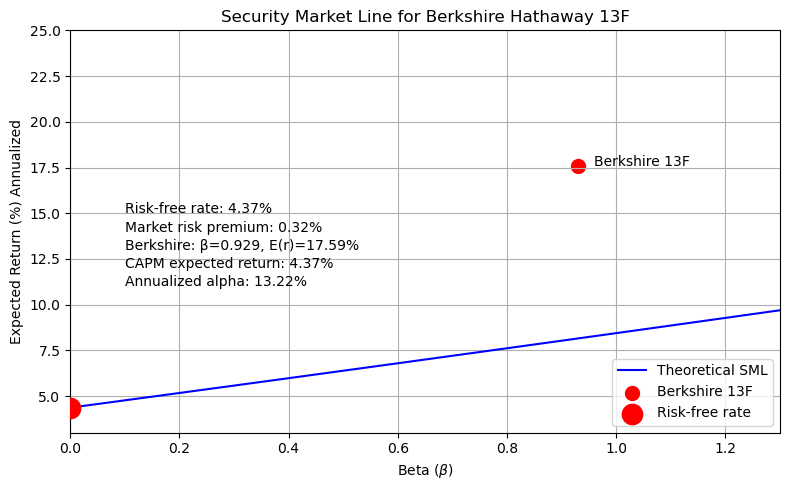

In [139]:
plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML
beta_values = np.linspace(0, 2.0, 100)
expected_return_monthly = rf_mean + beta_values * market_premium_mean
sml_values = (1 + expected_return_monthly) ** 12 - 1  #  annualized SML

# Plot the theoretical SML
plt.plot(beta_values, sml_values * 100, 'b-', label="Theoretical SML")

# Calculate actual annualized return for Berkshire
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1  

# Plot Berkshire (Berkshire Portfolio)
plt.scatter(market_beta, actual_return_annual * 100, s=100, color='red', label="Berkshire 13F")
plt.annotate('Berkshire 13F', (market_beta + 0.03, actual_return_annual * 100), fontsize=10)

# Plot risk-free point at (0, Risk-Free Rate)
rf_annualized = (1 + rf_mean) ** 12 - 1  #  risk-free rate annualization
plt.scatter(0, rf_annualized * 100, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate")

# Set axis limits and labels
plt.axis([0, 1.3, 3, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Return (%) Annualized')
plt.title('Security Market Line for Berkshire Hathaway 13F')

# Add legend
plt.legend(loc='lower right')

# Add text information on the plot
plt.text(0.1, 15, f"Risk-free rate: {rf_annualized * 100:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Market risk premium: {market_premium_mean * 100:.2f}%", fontsize=10)
plt.text(0.1, 13, f"Berkshire: β={market_beta:.3f}, E(r)={actual_return_annual * 100:.2f}%", fontsize=10)

# Calculate CAPM expected return for Berkshire
expected_return_annual = (1 + expected_return_monthly) ** 12 - 1
alpha_annualized = actual_return_annual - expected_return_annual  #  annualized alpha calculation

plt.text(0.1, 12, f"CAPM expected return: {expected_return_annual[0] * 100:.2f}%", fontsize=10)
plt.text(0.1, 11, f"Annualized alpha: {alpha_annualized[0] * 100:.2f}%", fontsize=10)


plt.tight_layout()
plt.show()

#### Question 2 - Berkshire Hathaway 13F
The Fama-French 3-factor model with SMB and HML.

In [141]:
# Fama-French 3-Factor Model Regression for r_brkp portfolio
formula = "r_brkp ~ 1 + MktRf + SMB + HML"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_brkp)

# Extract regression coefficients
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]

# Extract p-values
p_val_alpha = pval[0]
p_val_betaM = pval[1]
p_val_bSMB = pval[2]
p_val_bHML = pval[3]
r_squared = lm.rsquared

# Compute predicted expected return (annualized, in percentage)
SMB_mean = data_r_brk["SMB"].mean()
HML_mean = data_r_brk["HML"].mean()

predicted_return = (betaM * MktRf + bSMB * SMB_mean + bHML * HML_mean) * 12 * 100
actual_return = (data_r_brk["r_brkp"].mean() - rf_mean) * 12 * 100  # Actual annualized excess return
alpha_annualized = alpha * 12 * 100  # Convert alpha to annualized percentage

# Print regression results in a structured format
print("\nFama-French 3-Factor Model Results:")
print(f"{'Factor':<25}{'Coefficient':<15}{'p-value'}")
print("=" * 60)
print(f"{'Alpha (Monthly)':<25}{alpha:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized) in %':<25}{alpha_annualized:.4f}{'':>15}") 
print(f"{'Market Beta (β_M)':<25}{betaM:.4f}{p_val_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<25}{bSMB:.4f}{p_val_bSMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<25}{bHML:.4f}{p_val_bHML:>15.4f}")
print(f"{'R-squared':<25}{r_squared:.4f}{'':>15}")  
print("=" * 60)



Fama-French 3-Factor Model Results:
Factor                   Coefficient    p-value
Alpha (Monthly)          0.0103         0.0000
Alpha (Annualized) in %  12.3228               
Market Beta (β_M)        0.8383         0.0000
SMB Beta (β_SMB)         -0.1927         0.0002
HML Beta (β_HML)         0.2947         0.0000
R-squared                0.5580               


**2b. The Fama-French 3-factor model with SMB and HML.**

Looking now at the FF 3-factor model, we’re including two other factors in the analysis of the portfolio performance, size and the value. The market beta registered a decrease to 0.8383, so the portfolio is less sensitive to overall market movements. As for the SMB beta of -0.1927, since it’s negative, just like Berkshire’s, there’s a tendency toward large-cap stocks. The HML beta, 0.2947, also follows the tendency of Berkshire’s to prioritize value stocks, with higher book-to-market ratios. Finally, the annual alpha of 12.32% highlights the consistent portfolio ability to generate significant excess returns beyond what the market, size, and value factors can explain. As for the R-squared value, it suggests that 55.8% of the portfolio returns can be explained by the three factors, market, size and value, which is much higher when compared to the one of Berkshire’s. However, nearly 44.20% of the variation is still unexplained. 

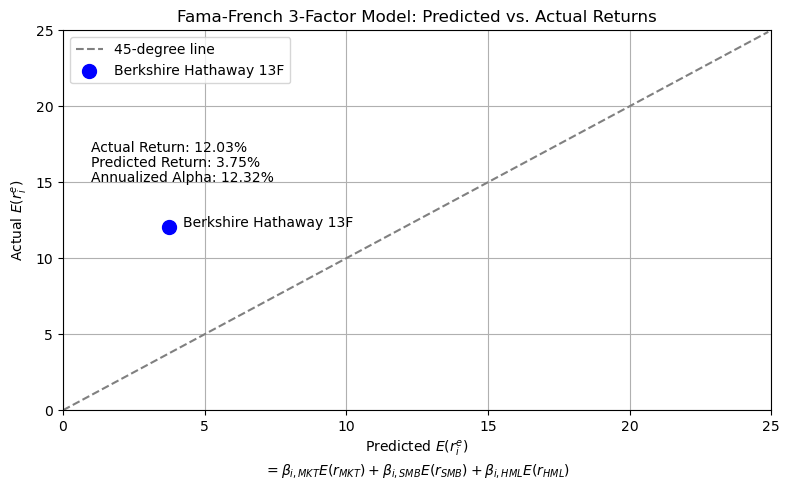

In [143]:
# Generate x = y reference line
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0, 25, 0.1), np.arange(0, 25, 0.1), linestyle='dashed', color='gray', label="45-degree line")

# Plot Berkshire Hathaway's actual vs. predicted return
plt.scatter(predicted_return, actual_return, color='blue', s=100, label='Berkshire Hathaway 13F')
plt.annotate("Berkshire Hathaway 13F", (predicted_return + 0.5, actual_return), fontsize=10)

# Add text annotations with key metrics
plt.text(1, 17, f"Actual Return: {actual_return:.2f}%", fontsize=10)
plt.text(1, 16, f"Predicted Return: {predicted_return:.2f}%", fontsize=10)
plt.text(1, 15, f"Annualized Alpha: {alpha_annualized:.2f}%", fontsize=10)


# Set plot properties
plt.axis([0, 25, 0, 25])
plt.grid(True)
plt.xlabel(r'Predicted $E(r_i^e)$'"\n"r'$=\beta_{i,MKT}E(r_{MKT}) + \beta_{i,SMB}E(r_{SMB}) + \beta_{i,HML}E(r_{HML})$')
plt.ylabel(r'Actual $E(r_i^e)$')
plt.title("Fama-French 3-Factor Model: Predicted vs. Actual Returns")
plt.legend()
plt.tight_layout()
plt.show()

#### Question 2 - Berkshire Hathaway 13F
The 5-factor model consisting of the FF3-factor model augmented with BAB and QMJ

In [145]:
# Run Regression for r_brkp Portfolio
formula = "r_brkp ~ 1 + MktRf + SMB + HML + QMJ + BAB"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_brkp)

# Extract Regression Outputs
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]
bQMJ = BHat[4]
bBAB = BHat[5]

# Extract p-values
p_alpha = pval[0]
p_betaM = pval[1]
p_SMB = pval[2]
p_HML = pval[3]
p_QMJ = pval[4]
p_BAB = pval[5]

# Extract R-squared
r_squared = lm.rsquared

# Print Results
print("\nOLS Regression Results:")
print("=" * 70)
print(f"{'Factor':<25}{'Coefficient':<15}{'p-value'}")
print("-" * 70)
print(f"{'Alpha':<25}{alpha:.4f}{p_alpha:>15.4f}")
print(f"{'Market Beta (β_M)':<25}{betaM:.4f}{p_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<25}{bSMB:.4f}{p_SMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<25}{bHML:.4f}{p_HML:>15.4f}")
print(f"{'QMJ Beta (β_QMJ)':<25}{bQMJ:.4f}{p_QMJ:>15.4f}")
print(f"{'BAB Beta (β_BAB)':<25}{bBAB:.4f}{p_BAB:>15.4f}")
print("-" * 70)
print(f"{'R-squared':<25}{r_squared:.4f}{'':>15}")  # No p-value for R-squared
print("=" * 70)



OLS Regression Results:
Factor                   Coefficient    p-value
----------------------------------------------------------------------
Alpha                    0.0071         0.0000
Market Beta (β_M)        0.9439         0.0000
SMB Beta (β_SMB)         -0.0769         0.1903
HML Beta (β_HML)         0.3034         0.0000
QMJ Beta (β_QMJ)         0.3224         0.0001
BAB Beta (β_BAB)         0.1134         0.0131
----------------------------------------------------------------------
R-squared                0.5854               


**2c. The 5-factor model consisting of the FF3-factor model augmented with BAB and QMJ.**

The 5-factor model reinforces and refines the findings of the 3-factor model, providing a more detailed picture of Berkshire Hathaway’s portfolio. The tendency toward value (positive HML), large cap (negative SMB), high quality (positive QMJ), and lower volatility (positive BAB) remains unchanged. The slight reduction in alpha highlights how the additional factors better capture some of the portfolio’s unique return drivers, while the still-strong alpha underscores Berkshire’s enduring ability to generate returns beyond what can be fully explained by these factors.

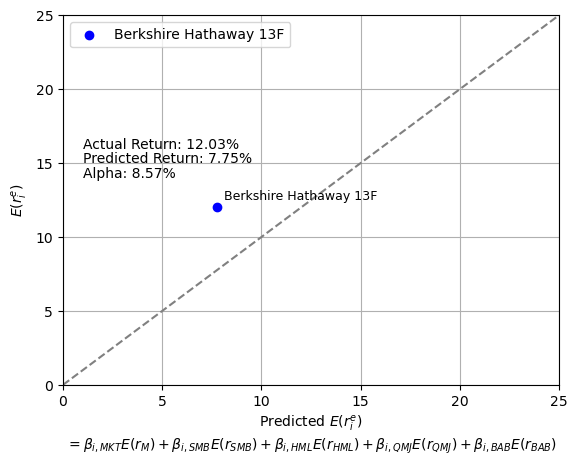

In [147]:
# Generate x = y Reference Line
plt.plot(np.arange(0, 25, 0.1), np.arange(0, 25, 0.1), linestyle='dashed', color='gray')

# Compute Predicted Expected Return (Annualized, in %)
predicted_return = (betaM * MktRf + bSMB * SMB + bHML * HML + bQMJ * QMJ + bBAB * BAB) * 12 * 100

# Compute Actual Excess Return for r_brk (Annualized, in %)
actual_return = (data_r_brkp["r_brkp"].mean() - rf) * 12 * 100

# Plot Scatter Point for Berkshire Hathaway
plt.scatter(predicted_return, actual_return, color='blue', label='Berkshire Hathaway 13F')

# Annotate the Point
plt.annotate("Berkshire Hathaway 13F", (predicted_return, actual_return), fontsize=9, xytext=(5, 5), textcoords='offset points')

# Add Additional Information to the Graph
plt.text(1, 16, f"Actual Return: {actual_return:.2f}%", fontsize=10)
plt.text(1, 15, f"Predicted Return: {predicted_return:.2f}%", fontsize=10)
plt.text(1, 14, f"Alpha: {alpha * 12 * 100:.2f}%", fontsize=10)


# Set Plot Properties
plt.axis([0, 25, 0, 25])
plt.grid(True)
plt.xlabel(
    r'Predicted $E(r_i^e)$' "\n"
    r'$=\beta_{i,MKT} E(r_M) + \beta_{i,SMB} E(r_{SMB}) + \beta_{i,HML} E(r_{HML})'
    r' + \beta_{i,QMJ} E(r_{QMJ}) + \beta_{i,BAB} E(r_{BAB})$'
)
plt.ylabel(r'$E(r_i^e)$')
plt.legend()
plt.show()

### Question 3

Compare the annualized average excess returns, volatility, and Sharpe ratio of, respectively, Berkshire and its portfolio of public stocks. Use the time period where data is available for both. Discuss the possible sources of differences between Berkshire and its portfolio of public stocks (you may find consulting Frazzini, Kabiller, and Pedersen (2018) helpful).

In [150]:
# ==============================
# Berkshire Hathaway Portfolio
# ==============================

# Annualized Average Excess Return
berkshire_excess_return = (data_r_brk["r_brk"] - data_r_brk["rf"]).mean() * 12

# Monthly Volatility
monthly_vol_brk = statistics.stdev(data_r_brk["r_brk"])

# Annualized Volatility
annual_vol_brk = monthly_vol_brk * np.sqrt(12)

# Sharpe Ratio
sr_brk = berkshire_excess_return / annual_vol_brk

# Print results in a structured format
print("\nBerkshire Hathaway Portfolio Performance:")
print("=" * 50)
print(f"{'Metric':<30}{'Value'}")
print("=" * 50)
print(f"{'Annualized Excess Return:':<30}{berkshire_excess_return:.2%}")
print(f"{'Monthly Volatility:':<30}{monthly_vol_brk:.2%}")
print(f"{'Annualized Volatility:':<30}{annual_vol_brk:.2%}")
print(f"{'Sharpe Ratio:':<30}{sr_brk:.2f}")
print("=" * 50)



Berkshire Hathaway Portfolio Performance:
Metric                        Value
Annualized Excess Return:     18.62%
Monthly Volatility:           6.82%
Annualized Volatility:        23.64%
Sharpe Ratio:                 0.79


In [151]:
# ==============================
# Berkshire 13F Portfolio
# ==============================

# Annualized Average Excess Return
berkshire13F_excess_return = (data_r_brkp["r_brkp"] - data_r_brkp["rf"]).mean() * 12

# Monthly Volatility
monthly_vol_brkp = statistics.stdev(data_r_brkp["r_brkp"])

# Annualized Volatility
annual_vol_brkp = monthly_vol_brkp * np.sqrt(12)

# Sharpe Ratio
sr_brkp = berkshire13F_excess_return / annual_vol_brkp

# Print results in a structured format
print("\nBerkshire 13F Portfolio Performance:")
print("=" * 50)
print(f"{'Metric':<30}{'Value'}")
print("=" * 50)
print(f"{'Annualized Excess Return:':<30}{berkshire13F_excess_return:.2%}")
print(f"{'Monthly Volatility:':<30}{monthly_vol_brkp:.2%}")
print(f"{'Annualized Volatility:':<30}{annual_vol_brkp:.2%}")
print(f"{'Sharpe Ratio:':<30}{sr_brkp:.2f}")
print("=" * 50)



Berkshire 13F Portfolio Performance:
Metric                        Value
Annualized Excess Return:     12.03%
Monthly Volatility:           4.71%
Annualized Volatility:        16.31%
Sharpe Ratio:                 0.74


In [152]:
import pandas as pd

# ==============================
# Create DataFrame for Comparison
# ==============================

comparison_df = pd.DataFrame({
    "Metric": [
        "Annualized Excess Return", 
        "Monthly Volatility", 
        "Annualized Volatility", 
        "Sharpe Ratio"
    ],
    "Berkshire": [
        f"{berkshire_excess_return:.2%}", 
        f"{monthly_vol_brk:.2%}", 
        f"{annual_vol_brk:.2%}", 
        f"{sr_brk:.2f}"
    ],
    "Berkshire 13F": [
        f"{berkshire13F_excess_return:.2%}", 
        f"{monthly_vol_brkp:.2%}", 
        f"{annual_vol_brkp:.2%}", 
        f"{sr_brkp:.2f}"
    ]
})

# Performance Comparison Table
print("\nPerformance Comparison:")
print("=" * 70)
print(f"{'Metric':<30}{'Berkshire':<20}{'Berkshire 13F'}")
print("=" * 70)

# Iterate over rows of the DataFrame to print values
for idx, row in comparison_df.iterrows():
    print(f"{row['Metric']:<30}{row['Berkshire']:>20}{row['Berkshire 13F']:>20}")

print("=" * 70)



Performance Comparison:
Metric                        Berkshire           Berkshire 13F
Annualized Excess Return                    18.62%              12.03%
Monthly Volatility                           6.82%               4.71%
Annualized Volatility                       23.64%              16.31%
Sharpe Ratio                                  0.79                0.74


The comparison between Berkshire Hathaway and its portfolio highlights key aspects of their performance. Berkshire Hathaway outshines its portfolio with an annualized excess return of 18.62% against 12.03%, reflecting the influence of private investments, strategic leverage, and operational advantages. Although Berkshire's total volatility (23.64%) is higher than the 13F portfolio’s (16.31%), it still maintains a Sharpe ratio of 0.79, slightly better than the portfolio’s 0.74, showing stronger risk-adjusted returns. This indicates that while the public stock portfolio contributes significantly, Berkshire's overall success stems from a combination of disciplined stock selection, private holdings, and an effective use of leverage, amplifying its ability to deliver superior long-term performance.

Additionally, Berkshire’s private investments contribute with additional value, providing diversification and access to opportunities not available in public markets. Furthermore, Berkshire benefits from structural advantages, including tax efficiencies and stable long-term capital, which enhance overall performance. These elements, combined with Warren Buffett’s strategic allocation and stock selection, enable Berkshire to outperform the public stock portfolio.


### Question 4
Buffett made several acquisitions of major stocks, including buying Lubrizol and Heinz
- a. E/P (earnings-to-price ratio) 
- b. B/M (book-to-market ratio)
- c. D/P (dividend-to-price ratio) 
- d. E/B (earnings-to-book ratio)
- e. 1-factor beta and alpha using the monthly excess returns before acquisition
- f. 5-factor loadings and alpha using the monthly excess returns before acquisition

#### Question 4 
- a. E/P (earnings-to-price ratio) 
- b. B/M (book-to-market ratio)
- c. D/P (dividend-to-price ratio) 
- d. E/B (earnings-to-book ratio)

In [156]:
# Define the data in a structured way
annual_report = {
    'Heinz (2012)': {
        'Price': 60.48,
        'EPS': 2.85,
        'Shares Outstanding (Diluted)': 323.312,
        'MCAP': 19553.90976,
        'Total Assets': 11983,
        'Total Liabilities': 9058.6,
        'Net Book Value': 2924.4,
        'Dividend per Share': 1.92,
        'Book Value per Share': 8.5,
        'Shareholder Equity': 2758.6
    },

    'Lubrizol (2010)': {
        'Price': 105.44,
        'EPS': 10.64,
        'Shares Outstanding (Diluted)': 68.8,
        'MCAP': 7254.272,
        'Total Assets': 4967,
        'Total Liabilities': 2686.3,
        'Net Book Value': 2280.7,
        'Dividend per Share': 1.39,
        'Book Value per Share': 31.9,
        'Shareholder Equity': 2193
    }
}    

# Function to calculate the financial ratios
def calculate_ratios(annual_report):
    ratios = {}
    for company, values in annual_report.items():
        price = values['Price']
        EPS = values['EPS']
        MCAP = values['MCAP']
        NBV = values['Net Book Value']
        dividend = values['Dividend per Share']
        BVpS = values['Book Value per Share']
        
        # Calculate ratios
        pe_ratio = price / EPS
        book_to_market = MCAP / NBV
        dividend_to_price = (dividend / EPS) * 100
        price_to_book = price / BVpS
        
        # Store the results in a dictionary, rounded to 4 decimals
        ratios[company] = {
            'Earnings to Price (P/E)': round(pe_ratio, 4),
            'Book to Market': round(book_to_market, 4),
            'Dividend to Price Ratio (%)': round(dividend_to_price, 4),
            'Price to Book': round(price_to_book, 4)
        }
    
    return ratios

# Calculate and display the ratios
ratios = calculate_ratios(annual_report)

# Display results in a structured table format
print("\nFinancial Ratios Comparison:")
print("=" * 80)
print(f"{'Metric':<40}{'Heinz (2012)':>15}{'Lubrizol (2010)':>15}")
print("=" * 80)

# Extract all metrics
metrics = list(next(iter(ratios.values())).keys())

# Iterate over each metric and print the values
for metric in metrics:
    heinz_value = ratios['Heinz (2012)'][metric]
    lubrizol_value = ratios['Lubrizol (2010)'][metric]
    print(f"{metric:<40}{heinz_value:>15}{lubrizol_value:>15}")

print("=" * 80)



Financial Ratios Comparison:
Metric                                     Heinz (2012)Lubrizol (2010)
Earnings to Price (P/E)                         21.2211         9.9098
Book to Market                                   6.6865         3.1807
Dividend to Price Ratio (%)                     67.3684        13.0639
Price to Book                                    7.1153         3.3053


#### Question 4 Heinz
e. 1-factor beta and alpha using the monthly excess returns before acquisition

In [158]:
# Filter Data before aquisition
# Taking the date from the PDF e.g. Takeover announcement date (14/02/2013)
data_r_hnz = data.loc["1976-11-30":"2013-01-31"]

In [159]:
print("Head")
print(data_r_hnz.head(1))
print("--"*50)
print("Tail")
print(data_r_hnz.tail(1))

Head
               r_brk  r_brkp  r_lz     r_hnz     rf     MKT     SMB     HML  \
Date                                                                          
1976-11-30  0.154412     NaN   NaN  0.044643  0.004  0.0036  0.0232  0.0151   

                 QMJ       BAB    UMD   MktRf  
Date                                           
1976-11-30 -0.020044  0.003814  0.029 -0.0004  
----------------------------------------------------------------------------------------------------
Tail
               r_brk    r_brkp  r_lz     r_hnz   rf     MKT     SMB     HML  \
Date                                                                          
2013-01-31  0.084784  0.041481   NaN  0.051144  0.0  0.0557  0.0039  0.0092   

                 QMJ       BAB     UMD   MktRf  
Date                                            
2013-01-31 -0.021462  0.044956 -0.0186  0.0557  


In [160]:
data_r_hnz = data_r_hnz

In [161]:
# Factor means
mu =data_r_hnz['r_hnz'].mean()
rf = data_r_hnz['rf'].mean()
mue = data_r_hnz.mean()-rf
MktRf = data_r_hnz['MktRf'].mean()
MKT = data_r_hnz['MKT'].mean()
SMB = data_r_hnz['SMB'].mean()
HML = data_r_hnz['HML'].mean()
QMJ = data_r_hnz['QMJ'].mean()
BAB = data_r_hnz['BAB'].mean()
UMD = data_r_hnz['UMD'].mean()

In [162]:
# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm

In [163]:
# Regression for Heinz portfolio (1-factor model)
formula = "r_hnz - rf ~ 1 + MktRf"  # excess returns

BHat, StdB, tstat, pval, lm = reg(formula, data_r_hnz)

# Results:
alpha_monthly = BHat[0]
market_beta = BHat[1]
p_val_alpha = pval[0]
p_val_beta = pval[1]
r_squared = lm.rsquared

# Calculate key metrics
rf_mean = rf
market_premium_mean = MktRf
portfolio_mean_return = mu

# Annualize returns
alpha_annualized = (1 + alpha_monthly) ** 12 - 1
expected_return_monthly = rf_mean + market_beta * market_premium_mean
expected_return_annual = (1 + expected_return_monthly) ** 12 - 1
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1

print("\nCAPM Analysis for Heinz:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha (Monthly)':<35}{alpha_monthly:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized)':<35}{alpha_annualized:.4f}{'':>15}")  
print(f"{'Beta':<35}{market_beta:.4f}{p_val_beta:>15.4f}")
print(f"{'Expected Return (Annualized)':<35}{expected_return_annual:.4f} ({expected_return_annual*100:.2f}%)")
print(f"{'Actual Return (Annualized)':<35}{actual_return_annual:.4f} ({actual_return_annual*100:.2f}%)")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  
print("=" * 70)



CAPM Analysis for Heinz:
Factor                             Coefficient    p-value
Alpha (Monthly)                    0.0126         0.0000
Alpha (Annualized)                 0.1619               
Beta                               0.5738         0.0000
Expected Return (Annualized)       0.0628 (6.28%)
Actual Return (Annualized)         0.1738 (17.38%)
R-squared                          0.1924               


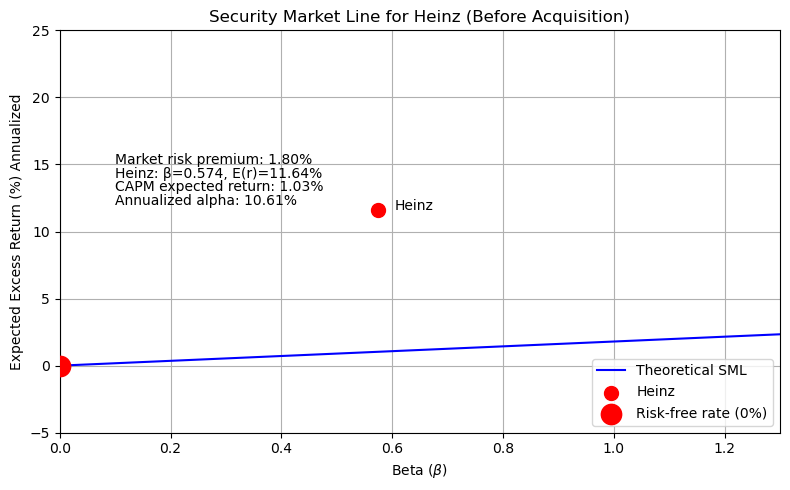

In [164]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML (Annualized Excess Returns)
beta_values = np.linspace(0, 2.0, 100)
sml_values = (MktRf * beta_values) * 12 * 100  # Since we're using excess returns

# Plot the theoretical SML
plt.plot(beta_values, sml_values, 'b-', label="Theoretical SML")

# Compute actual annualized excess return for Heinz
actual_excess_return_annual = ((1 + mu - rf) ** 12 - 1) * 100  # Annualized excess return in %

# Plot Heinz on SML
plt.scatter(market_beta, actual_excess_return_annual, s=100, color='red', label="Heinz")
plt.annotate('Heinz', (market_beta + 0.03, actual_excess_return_annual), fontsize=10)

# Plot risk-free rate (which is 0% in excess return space)
plt.scatter(0, 0, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate (0%)")

# Set axis limits and labels
plt.axis([0, 1.3, -5, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Excess Return (%) Annualized')
plt.title('Security Market Line for Heinz (Before Acquisition)')

# Add legend
plt.legend(loc='lower right')

# Add text information on the plot
plt.text(0.1, 15, f"Market risk premium: {MktRf * 12 * 100:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Heinz: β={market_beta:.3f}, E(r)={actual_excess_return_annual:.2f}%", fontsize=10)

# Calculate CAPM expected excess return for Heinz
capm_expected_excess_return = (market_beta * MktRf) * 12 * 100  # Annualized CAPM return
alpha_annualized = actual_excess_return_annual - capm_expected_excess_return  # Alpha calculation

plt.text(0.1, 13, f"CAPM expected return: {capm_expected_excess_return:.2f}%", fontsize=10)
plt.text(0.1, 12, f"Annualized alpha: {alpha_annualized:.2f}%", fontsize=10)


plt.tight_layout()
plt.show()


#### Question 4 Heinz
f. 5-factor loadings and alpha using the monthly excess returns before acquisition

In [166]:
# Run Regression for Heinz Portfolio (5-Factor Model) with Excess Returns
formula = "r_hnz - rf ~ 1 + MktRf + SMB + HML + QMJ + BAB"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_hnz)

# Extract Regression Outputs
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]
bQMJ = BHat[4]
bBAB = BHat[5]

# Extract p-values
p_val_alpha = pval[0]
p_val_betaM = pval[1]
p_val_bSMB = pval[2]
p_val_bHML = pval[3]
p_val_bQMJ = pval[4]
p_val_bBAB = pval[5]
r_squared = lm.rsquared

# Print Results
print("\nOLS Regression Results:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha':<35}{alpha:.4f}{p_val_alpha:>15.4f}")
print(f"{'Market Beta (β_M)':<35}{betaM:.4f}{p_val_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<35}{bSMB:.4f}{p_val_bSMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<35}{bHML:.4f}{p_val_bHML:>15.4f}")
print(f"{'QMJ Beta (β_QMJ)':<35}{bQMJ:.4f}{p_val_bQMJ:>15.4f}")
print(f"{'BAB Beta (β_BAB)':<35}{bBAB:.4f}{p_val_bBAB:>15.4f}")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  
print("=" * 70)


OLS Regression Results:
Factor                             Coefficient    p-value
Alpha                              0.0069         0.0081
Market Beta (β_M)                  0.8720         0.0000
SMB Beta (β_SMB)                   -0.0422         0.6729
HML Beta (β_HML)                   0.2713         0.0095
QMJ Beta (β_QMJ)                   0.7128         0.0000
BAB Beta (β_BAB)                   0.1490         0.0563
R-squared                          0.2920               


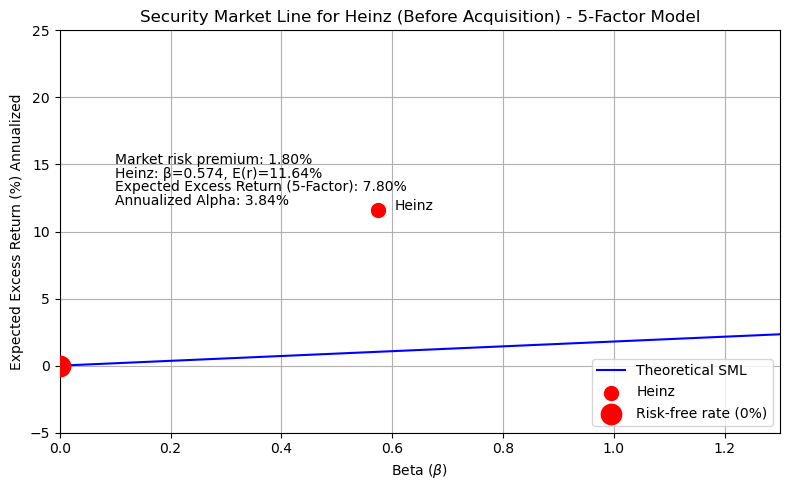

In [167]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML (Annualized Excess Returns)
beta_values = np.linspace(0, 2.0, 100)
sml_values = (MktRf * beta_values) * 12 * 100  # Since we're using excess returns

# Plot the theoretical SML
plt.plot(beta_values, sml_values, 'b-', label="Theoretical SML")

# Compute the expected return using the 5-factor model
expected_return_5factor = (
    (betaM * MktRf) + (bSMB * SMB) + (bHML * HML) + (bQMJ * QMJ) + (bBAB * BAB)
) * 12 * 100  # Annualized excess return in %

# Compute actual annualized excess return for Heinz
actual_excess_return_annual = ((1 + mu - rf) ** 12 - 1) * 100  # Annualized excess return in %

# Plot Heinz on the SML
plt.scatter(market_beta, actual_excess_return_annual, s=100, color='red', label="Heinz")
plt.annotate('Heinz', (market_beta + 0.03, actual_excess_return_annual), fontsize=10)

# Plot risk-free rate (which is 0% in excess return space)
plt.scatter(0, 0, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate (0%)")

# Set axis limits and labels
plt.axis([0, 1.3, -5, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Excess Return (%) Annualized')
plt.title('Security Market Line for Heinz (Before Acquisition) - 5-Factor Model')

# Add legend
plt.legend(loc='lower right')

# Add text information on the plot
plt.text(0.1, 15, f"Market risk premium: {MktRf * 12 * 100:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Heinz: β={market_beta:.3f}, E(r)={actual_excess_return_annual:.2f}%", fontsize=10)

# Calculate expected excess return using the 5-factor model
capm_expected_excess_return = (
    (betaM * MktRf) + (bSMB * SMB) + (bHML * HML) + (bQMJ * QMJ) + (bBAB * BAB)
) * 12 * 100  # Annualized excess return in %

# Calculate the alpha (5-factor model) for Heinz
alpha_annualized = actual_excess_return_annual - capm_expected_excess_return  # Alpha calculation

# Add the CAPM expected excess return and alpha to the plot
plt.text(0.1, 13, f"Expected Excess Return (5-Factor): {capm_expected_excess_return:.2f}%", fontsize=10)
plt.text(0.1, 12, f"Annualized Alpha: {alpha_annualized:.2f}%", fontsize=10)


plt.tight_layout()
plt.show()

#### Question 4 Lubrizol
e. 1-factor beta and alpha using the monthly excess returns before acquisition

In [169]:
r_lz = data.dropna(subset=['r_lz'])

In [170]:
# Filter Data before aquisition
# Taking the date from the PDF e.g. Takeover announcement date 14/03/2011
data_r_lz = r_lz.loc["1976-11-30":"2011-02-28"]

In [171]:
print("Head")
print(data_r_lz.head(1))
print("--"*50)
print("Tail")
print(data_r_lz.tail(1))

Head
               r_brk    r_brkp     r_lz     r_hnz      rf     MKT     SMB  \
Date                                                                        
1997-01-31  0.020848  0.089945  0.08871  0.118881  0.0045  0.0498 -0.0184   

               HML       QMJ       BAB     UMD   MktRf  
Date                                                    
1997-01-31 -0.0164  0.006047  0.045404  0.0195  0.0453  
----------------------------------------------------------------------------------------------------
Tail
               r_brk    r_brkp      r_lz     r_hnz      rf     MKT     SMB  \
Date                                                                         
2011-02-28  0.070456  0.014595  0.016471  0.057263  0.0001  0.0349  0.0152   

               HML       QMJ       BAB     UMD   MktRf  
Date                                                    
2011-02-28  0.0109 -0.009476  0.006887  0.0201  0.0348  


In [172]:
data_r_lz

,r_brk,r_brkp,r_lz,r_hnz,rf,MKT,SMB,HML,QMJ,BAB,UMD,MktRf
Date,,,,,,,,,,,,
1997-01-31,0.020848,0.089945,0.088710,0.118881,0.0045,0.0498,-0.0184,-0.0164,0.006047,0.045404,0.0195,0.0453
1997-02-28,0.020267,0.026685,0.033333,0.040625,0.0039,-0.0049,-0.0290,0.0519,0.008893,0.060887,-0.0205,-0.0088
1997-03-31,0.019697,-0.074109,-0.061372,-0.044084,0.0043,-0.0502,-0.0038,0.0381,0.007419,0.031012,0.0097,-0.0545
1997-04-30,0.049736,0.113250,0.007692,0.050633,0.0043,0.0404,-0.0566,-0.0007,0.038088,-0.015411,0.0492,0.0361
1997-05-30,0.131698,0.070498,0.095420,0.036145,0.0049,0.0674,0.0489,-0.0387,-0.004046,-0.012627,-0.0516,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-10-29,-0.040128,0.035203,-0.032840,0.036732,0.0001,0.0388,0.0115,-0.0259,0.004089,0.021475,0.0163,0.0387
2010-11-30,0.005084,0.013926,0.023710,-0.017104,0.0001,0.0060,0.0370,-0.0090,-0.003232,-0.004422,0.0253,0.0059
2010-12-31,0.003468,0.059192,0.022188,0.033976,0.0001,0.0682,0.0070,0.0381,-0.046387,-0.000299,-0.0319,0.0681


In [173]:
# Factor means
mu =data_r_lz['r_lz'].mean()
rf = data_r_lz['rf'].mean()
mue = data_r_lz.mean()-rf
MktRf = data_r_lz['MktRf'].mean()
MKT = data_r_lz['MKT'].mean()
SMB = data_r_lz['SMB'].mean()
HML = data_r_lz['HML'].mean()
QMJ = data_r_lz['QMJ'].mean()
BAB = data_r_lz['BAB'].mean()
UMD = data_r_lz['UMD'].mean()

In [174]:
# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm

In [175]:
# Regression for Heinz portfolio (1-factor model)
formula = "r_lz - rf ~ 1 + MktRf" #excess returns

BHat, StdB, tstat, pval, lm = reg(formula, data_r_lz)

# Results:
alpha_monthly = BHat[0]
market_beta = BHat[1]
p_val_alpha = pval[0]
p_val_beta = pval[1]
r_squared = lm.rsquared

# Calculate key metrics
rf_mean = rf
market_premium_mean = MktRf
portfolio_mean_return = mu

# Annualize returns
alpha_annualized = (1 + alpha_monthly) ** 12 - 1
expected_return_monthly = rf_mean + market_beta * market_premium_mean
expected_return_annual = (1 + expected_return_monthly) ** 12 - 1
actual_return_annual = (1 + portfolio_mean_return) ** 12 - 1

print("\nCAPM Analysis for Lubrisol:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha (Monthly)':<35}{alpha_monthly:.4f}{p_val_alpha:>15.4f}")
print(f"{'Alpha (Annualized)':<35}{alpha_annualized:.4f}{'':>15}")  
print(f"{'Beta':<35}{market_beta:.4f}{p_val_beta:>15.4f}")
print(f"{'Expected Return (Annualized)':<35}{expected_return_annual:.4f} ({expected_return_annual*100:.2f}%)")
print(f"{'Actual Return (Annualized)':<35}{actual_return_annual:.4f} ({actual_return_annual*100:.2f}%)")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  
print("=" * 70)


CAPM Analysis for Lubrisol:
Factor                             Coefficient    p-value
Alpha (Monthly)                    0.0121         0.0315
Alpha (Annualized)                 0.1551               
Beta                               0.9439         0.0000
Expected Return (Annualized)       0.0480 (4.80%)
Actual Return (Annualized)         0.1751 (17.51%)
R-squared                          0.2902               


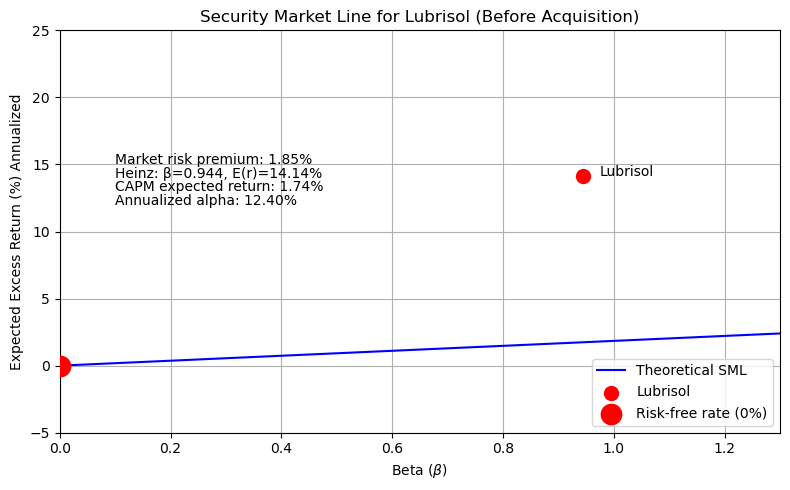

In [176]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML (Annualized Excess Returns)
beta_values = np.linspace(0, 2.0, 100)
sml_values = (MktRf * beta_values) * 12 * 100  # Since we're using excess returns

# Plot the theoretical SML
plt.plot(beta_values, sml_values, 'b-', label="Theoretical SML")

# Compute actual annualized excess return for Heinz
actual_excess_return_annual = ((1 + mu - rf) ** 12 - 1) * 100  # Annualized excess return in %

# Plot Heinz on SML
plt.scatter(market_beta, actual_excess_return_annual, s=100, color='red', label="Lubrisol")
plt.annotate('Lubrisol', (market_beta + 0.03, actual_excess_return_annual), fontsize=10)

# Plot risk-free rate (which is 0% in excess return space)
plt.scatter(0, 0, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate (0%)")

# Set axis limits and labels
plt.axis([0, 1.3, -5, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Excess Return (%) Annualized')
plt.title('Security Market Line for Lubrisol (Before Acquisition)')

# Add legend
plt.legend(loc='lower right')

# Add text information on the plot
plt.text(0.1, 15, f"Market risk premium: {MktRf * 12 * 100:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Heinz: β={market_beta:.3f}, E(r)={actual_excess_return_annual:.2f}%", fontsize=10)

# Calculate CAPM expected excess return for Heinz
capm_expected_excess_return = (market_beta * MktRf) * 12 * 100  # Annualized CAPM return
alpha_annualized = actual_excess_return_annual - capm_expected_excess_return  # Alpha calculation

plt.text(0.1, 13, f"CAPM expected return: {capm_expected_excess_return:.2f}%", fontsize=10)
plt.text(0.1, 12, f"Annualized alpha: {alpha_annualized:.2f}%", fontsize=10)

plt.tight_layout()
plt.show()


#### Question 4 Lubrizol
f. 5-factor loadings and alpha using the monthly excess returns before acquisition

In [178]:
# Run Regression for Lubrizol Portfolio (5-Factor Model) with Excess Returns
formula = "r_lz - rf ~ 1 + MktRf + SMB + HML + QMJ + BAB"
BHat, StdB, tstat, pval, lm = reg(formula, data_r_lz)

# Extract Regression Outputs
alpha = BHat[0]
betaM = BHat[1]
bSMB = BHat[2]
bHML = BHat[3]
bQMJ = BHat[4]
bBAB = BHat[5]

# Extract p-values
p_val_alpha = pval[0]
p_val_betaM = pval[1]
p_val_bSMB = pval[2]
p_val_bHML = pval[3]
p_val_bQMJ = pval[4]
p_val_bBAB = pval[5]
r_squared = lm.rsquared

# Print Results
print("\nOLS Regression Results:")
print("=" * 70)
print(f"{'Factor':<35}{'Coefficient':<15}{'p-value'}")
print("=" * 70)
print(f"{'Alpha':<35}{alpha:.4f}{p_val_alpha:>15.4f}")
print(f"{'Market Beta (β_M)':<35}{betaM:.4f}{p_val_betaM:>15.4f}")
print(f"{'SMB Beta (β_SMB)':<35}{bSMB:.4f}{p_val_bSMB:>15.4f}")
print(f"{'HML Beta (β_HML)':<35}{bHML:.4f}{p_val_bHML:>15.4f}")
print(f"{'QMJ Beta (β_QMJ)':<35}{bQMJ:.4f}{p_val_bQMJ:>15.4f}")
print(f"{'BAB Beta (β_BAB)':<35}{bBAB:.4f}{p_val_bBAB:>15.4f}")
print(f"{'R-squared':<35}{r_squared:.4f}{'':>15}")  # No p-value for R-squared
print("=" * 70)


OLS Regression Results:
Factor                             Coefficient    p-value
Alpha                              0.0066         0.2194
Market Beta (β_M)                  1.2130         0.0000
SMB Beta (β_SMB)                   0.2247         0.1840
HML Beta (β_HML)                   0.9286         0.0000
QMJ Beta (β_QMJ)                   0.3726         0.1555
BAB Beta (β_BAB)                   0.0076         0.9547
R-squared                          0.4301               


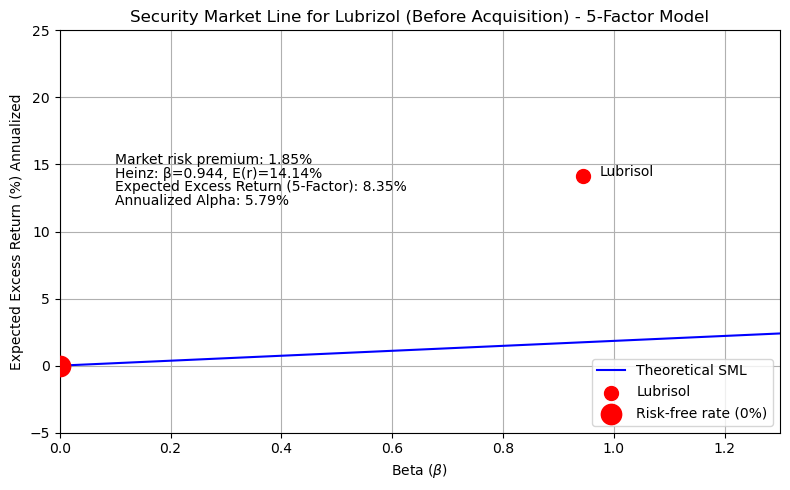

In [179]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate beta values for theoretical SML (Annualized Excess Returns)
beta_values = np.linspace(0, 2.0, 100)
sml_values = (MktRf * beta_values) * 12 * 100  # Since we're using excess returns

# Plot the theoretical SML
plt.plot(beta_values, sml_values, 'b-', label="Theoretical SML")

# Compute the expected return using the 5-factor model
expected_return_5factor = (
    (betaM * MktRf) + (bSMB * SMB) + (bHML * HML) + (bQMJ * QMJ) + (bBAB * BAB)
) * 12 * 100  # Annualized excess return in %

# Compute actual annualized excess return for Heinz
actual_excess_return_annual = ((1 + mu - rf) ** 12 - 1) * 100  # Annualized excess return in %

# Plot Heinz on the SML
plt.scatter(market_beta, actual_excess_return_annual, s=100, color='red', label="Lubrisol")
plt.annotate('Lubrisol', (market_beta + 0.03, actual_excess_return_annual), fontsize=10)

# Plot risk-free rate (which is 0% in excess return space)
plt.scatter(0, 0, s=200, color='red', linewidth=1.5, zorder=5, label="Risk-free rate (0%)")

# Set axis limits and labels
plt.axis([0, 1.3, -5, 25])
plt.grid(True)
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel('Expected Excess Return (%) Annualized')
plt.title('Security Market Line for Lubrizol (Before Acquisition) - 5-Factor Model')

# Add legend
plt.legend(loc='lower right')

# Add text information on the plot
plt.text(0.1, 15, f"Market risk premium: {MktRf * 12 * 100:.2f}%", fontsize=10)
plt.text(0.1, 14, f"Heinz: β={market_beta:.3f}, E(r)={actual_excess_return_annual:.2f}%", fontsize=10)

# Calculate expected excess return using the 5-factor model
capm_expected_excess_return = (
    (betaM * MktRf) + (bSMB * SMB) + (bHML * HML) + (bQMJ * QMJ) + (bBAB * BAB)
) * 12 * 100  # Annualized excess return in %

# Calculate the alpha (5-factor model) for Heinz
alpha_annualized = actual_excess_return_annual - capm_expected_excess_return  # Alpha calculation

# Add the CAPM expected excess return and alpha to the plot
plt.text(0.1, 13, f"Expected Excess Return (5-Factor): {capm_expected_excess_return:.2f}%", fontsize=10)
plt.text(0.1, 12, f"Annualized Alpha: {alpha_annualized:.2f}%", fontsize=10)


plt.tight_layout()
plt.show()

### Question 4 Summary:

Discretionary investors, who combine tailored fundamental analysis with specific screening criteria, would find Lubrizol and Heinz particularly appealing based on their financial metrics and market positioning. Both companies show strong fundamentals, with high Book-to-Market ratios (Lubrizol of 3.1807 and Heinz of 6.6865), suggesting **significant undervaluation** compared to their book values. Heinz offers an exceptional dividend yield of 67.37%, while Lubrizol delivers a solid 13.06%, making them attractive for income-focused investors. CAPM analysis highlights their ability to generate **excess returns** beyond **market expectations**, with annualized alphas of 15.51% for Lubrizol and 16.19% for Heinz, pointing to **robust performance.**

Factor exposures further enhance their attractiveness. Heinz shows a meaningful tilt toward high-quality stocks (QMJ beta is 0.7128), reflecting **its stable earnings and profitability**, along with a preference for **lower-risk investments** (BAB beta of 0.1490). Lubrizol, on the other hand, stands out for its **strong value orientation**, as evidenced by its high HML beta of 0.9286, reinforcing its appeal as a value-driven investment. Market beta differences between the two also reflect **varied risk profiles.** Heinz’s lower beta suggests reduced volatility, while Lubrizol’s higher beta aligns with a more market-responsive approach.

These qualities align well with the criteria of a discretionary investor seeking undervalued, income-generating, and high-quality stocks. Lubrizol and Heinz exemplify strong potential for strategic acquisitions, offering unique sector positions that make them even more appealing to a discretionary investor. 
